# Capstone: Budget & Environmentally Friendly Vehicle Recommender System  
**Author:** Sundus Yawar  
**Sprint:** 2  
**Student ID:** 583854  
**Institute:** BrainStation  
**Capstone Supervisor:** Amir Rahimizadeh

# Table of Content
[Overview](#Overview)
- [Data Dictionary](#Data-Dictionary)
- [What was Done in Previous Sprints](#What-was-Done-in-Previous-Sprints)
    - [Sprint 1](#Sprint-1)
    - [Sprint 2](#Sprint-2)
- [Focus for this Sprint](#Focus-for-this-Sprint)  
- [Why did I choose the clustering algorithms that I chose?](#Why-did-I-choose-the-clustering-algorithms-that-I-chose?)
  
[Importing & Verifying the data](#Importing-&-Verifying-the-data)    

[Minimal Data Wrangling for this Sprint](#Minimal-Data-Wrangling-for-this-Sprint)    

[Scaling the Data and Performing Onehotencoding](#Scaling-the-Data-and-Performing-Onehotencoding)    

[Backward Feature Selection with K-Means](#Backward-Feature-Selection-with-K-Means)  
- [Some Functions for Modeling](#Some-Functions-for-Modeling)
- [Function for Dropping Feature 1 at a Time](#Function-for-Dropping-Feature-1-at-a-Time)
- [Modeling](#Modeling)
    - [All Features Included](#All-Features-Included)
    - [Drop Make](#Drop-Make)
    - [Drop Transmission Type](#Drop-Transmission-Type)
    - [Drop Fuel Type](#Drop-Fuel-Type)
    - [Drop Model_Year](#Drop-Model_Year)
    - [Investigating the Duplicates Observed During Clustering Warning](#Investigating-the-Duplicates-Observed-During-Clustering-Warning)
- [Joining Model Stats DataFrames for Feature Selection](#Joining-Model-Stats-DataFrames-for-Feature-Selection)  
  
[Advanced Modelling](#Advanced-Modelling)
- [Baseline DBScan Model](#Baseline-DBScan-Model)  
    - [Determining optimal eps Value using KNN](#Determining-optimal-eps-Value-using-KNN)  
    - [Baseline Modeling](#Baseline-Modeling)  
- [Hyperparameters Tuning](#Hyperparameters-Tuning)  
- [Final Modelling Based on Hyperparameters Tuning](#Final-Modelling-Based-on-Hyperparameters-Tuning)  
    - [Visualizing the Clusters](#Visualizing-the-Clusters)  
    - [Analyzing the Clusters to Determine Legitimacy of the Formed Clusters and Deriving Insights](#Analyzing-the-Clusters-to-Determine-Legitimacy-of-the-Formed-Clusters-and-Deriving-Insights)  
        - [Result of the Cluster Analysis](#Result-of-the-Cluster-Analysis)  
        - [Reflection](#Reflection)  
            - [Testing Insight Derived from Reflection in the Final Model](#Testing-Insight-Derived-from-Reflection-in-the-Final-Model)
    - [Concatenating the Labels to the main dataframe](#Concatenating-the-Labels-to-the-main-dataframe)  
      
[Adding Car Prices to the Dataset](#Adding-Car-Prices-to-the-Dataset)  
    - [Another Prices Dataset](#Another-Prices-Dataset)  
    - [Correcting the Strange Prices](#Correcting-the-Strange-Prices)

[Dropping Irrelevant Columns and Exporting the Final DataFrame](#Dropping-Irrelevant-Columns-and-Exporting-the-Final-DataFrame)

# Overview
The dataset I got for fuel consumption rating had features that can help determine whether a vehicle is green or not green, however, it doesn't contain labels for the vehicles whether they are green or not green. Since the data does not contain any labels, supervised machine learning algorithms can't be used. So, I'll be using clustering algorithms (unsupervised learning) to determine the pattern and then analyze the clusters to label them as green or not green.
## Data Dictionary 

**Data Dictionary for transmission:**  
| Acronym | Definition                |
|:---------|:---------------------------|
| A       | Automatic                 |
| AM      | Automated manual          |
| AS      | Automatic with select shift |
| AV      | Continuously variable     |
| M       | Manual                    |
| 3 – 10  | Number of gears           |    
  
**Data Dictionary for fuel type:**   

| Code | Fuel Type           |
|:------|:---------------------|
| X    | Regular gasoline   |
| Z    | Premium gasoline   |
| D    | Diesel              |
| E    | Ethanol (E85)      |
| N    | Natural gas         |  
  
  
| Attribute         | Description                                                                             |
|:------------------|:----------------------------------------------------------------------------------------|
| Fuel Consumption  | City and highway fuel consumption ratings are shown in L/100 km and in mpg.           |
| CO2 Emissions     | Tailpipe emissions of carbon dioxide (g/km) for combined city and highway driving.     |
| CO2 Rating        | CO2 emissions rating on a scale from 1 (worst) to 10 (best).                             |
| Smog Rating       | Smog-forming pollutants emissions rating on a scale from 1 (worst) to 10 (best).        |  
  
## What was Done in Previous Sprints
### Sprint 1
- Data cleaning and wrangling
- EDA
- Some prices added from prices dataset to the fuel consumption rating dataset
### Sprint 2
- used clean data from sprint 1 ommitting the prices column as some were missing and didn't need to include prices for modeling anyways as explained in the overview of the Sprint 2 capstone
- Performed Feature Selection and Exngineering for columns with multicollinearity (dealt with numerical (VIF ANalysis) and categorical columns (chi2 test))
- Baseline Modeling, tuning, and evaluation based on only 4 features as a test
- Visualization of the clusters
- Post processing and basic analysis of the clusters
## Focus for this Sprint
- Use the feature selected data from Sprint 2 for further feature selection using backward selection as there are columns I am not sure about whether to include or not. These columns include, Make, Transmission_Type and Fuel_Type.
- After backward feature selection, use DBScan model as a final clustering algorithm.
- Analyze the clusters to label them as green or not green
- Add missing data for the prices
- Build the streamlit app  
## Why did I choose the clustering algorithms that I chose?
I chose 2 Models, KMeans and DBScan. KMeans is a very basic clustering algorithm which is quick for training and clustering, so it is mainly used for baseline modelling. I chose DBScan because it is an advanced model and the advantage it has over KMeans is that KMeans only does clustering in circular shape only. Whereas DBScan can detect and create clusters in other shapes. Also, with KMeans you have to define number of clusters. Whereas in DBScan it selects number of clusters on its own. For more details see respective sections. This is just high level.

# Importing & Verifying the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
fuel_cons_rating = pd.read_csv("Sprint2_featureSelection_result.csv")

In [3]:
fuel_cons_rating.shape

(6951, 9)

In [4]:
fuel_cons_rating.columns

Index(['Unnamed: 0', 'Model_Year', 'Make', 'Vehicle_Class', 'Transmission',
       'Fuel_Type', 'Fuel_Consumption-Comb(L/100 km)', 'CO2_Emissions(g/km)',
       'Smog_Rating'],
      dtype='object')

It added an unnecessary column called 'Unnamed: 0', so just removing that

In [5]:
fuel_cons_rating.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
#sanity check
fuel_cons_rating.head()

,Model_Year,Make,Vehicle_Class,Transmission,Fuel_Type,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
0,2017,ACURA,COMPACT,AM8,Z,8.2,192,6
1,2017,ACURA,SUV - SMALL,AS9,Z,11.0,259,6
2,2017,ACURA,SUV - SMALL,AS9,Z,10.7,251,6
3,2017,ACURA,SUV - SMALL,AM7,Z,9.0,210,6
4,2017,ACURA,TWO-SEATER,AM9,Z,11.0,261,6


# Minimal Data Wrangling for this Sprint

In [7]:
fuel_cons_rating.select_dtypes(include=['int64']).columns.tolist()

['Model_Year', 'CO2_Emissions(g/km)', 'Smog_Rating']

I want Model_Year to be categorical rather than numeric because I dont want to apply standard scalar on year.

In [8]:
fuel_cons_rating['Model_Year'] = fuel_cons_rating['Model_Year'].astype('object')

In [9]:
# sanity check
fuel_cons_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6951 entries, 0 to 6950
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Model_Year                       6951 non-null   object 
 1   Make                             6951 non-null   object 
 2   Vehicle_Class                    6951 non-null   object 
 3   Transmission                     6951 non-null   object 
 4   Fuel_Type                        6951 non-null   object 
 5   Fuel_Consumption-Comb(L/100 km)  6951 non-null   float64
 6   CO2_Emissions(g/km)              6951 non-null   int64  
 7   Smog_Rating                      6951 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 434.6+ KB


# Scaling the Data and Performing Onehotencoding
I am scaling the data since fuel consumption, co2 emissions, smog rating have different value scales. And all categorical columns must be one hot encoded for the model to work.

In [10]:
from sklearn.preprocessing import StandardScaler

df_for_clustering = fuel_cons_rating.copy()

# Separating categorical and numerical columns 
categorical_columns = df_for_clustering.select_dtypes(include=['object']).columns
numerical_columns = ['Fuel_Consumption-Comb(L/100 km)', 'CO2_Emissions(g/km)', 'Smog_Rating']

# Instantiate
scaler = StandardScaler()
# Fit and Transform
df_for_clustering[numerical_columns] = scaler.fit_transform(df_for_clustering[numerical_columns])

df_for_clustering.head()

,Model_Year,Make,Vehicle_Class,Transmission,Fuel_Type,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
0,2017,ACURA,COMPACT,AM8,Z,-0.990427,-1.026786,0.698072
1,2017,ACURA,SUV - SMALL,AS9,Z,0.010211,0.072781,0.698072
2,2017,ACURA,SUV - SMALL,AS9,Z,-0.097001,-0.058511,0.698072
3,2017,ACURA,SUV - SMALL,AM7,Z,-0.704531,-0.731380,0.698072
4,2017,ACURA,TWO-SEATER,AM9,Z,0.010211,0.105604,0.698072


In [11]:
categorical_columns

Index(['Model_Year', 'Make', 'Vehicle_Class', 'Transmission', 'Fuel_Type'], dtype='object')

In [12]:
df_for_clustering = pd.get_dummies(df_for_clustering, columns=categorical_columns, prefix=categorical_columns)
# sanity check
df_for_clustering.head()

C:\Users\Sundus Yawar\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,Model_Year_2017,Model_Year_2018,Model_Year_2019,Model_Year_2020,Model_Year_2021,Model_Year_2022,Model_Year_2023,...,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel_Type_D,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z
0,-0.990427,-1.026786,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.010211,0.072781,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.097001,-0.058511,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.704531,-0.731380,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.010211,0.105604,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Sanity check**  
So, here I see that after applying one hot encoding, I have 95 columns. I just want to check unique value for each of my categorical columns to ensure that it adds up to 95 to ensure that all categorical columns got one hot encoded.

In [13]:
# Sanity Check
sum = fuel_cons_rating['Model_Year'].nunique() + fuel_cons_rating['Make'].nunique() + fuel_cons_rating['Vehicle_Class'].nunique()\
      + fuel_cons_rating['Transmission'].nunique() + fuel_cons_rating['Fuel_Type'].nunique()
sum

92

This makes sense, 92 is sum for all the categorical columns 1 hot encoded, and I have 3 numerical columns, 92+3=95. So, it did all the columns which is great.

# Backward Feature Selection with K-Means
## Some Functions for Modeling

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [15]:
def run_modeling(df):
    #n_samples=6951 should be >= n_clusters=10920
    ks = [2,15,22,26,30,52,92,104,105,184,210,420,840,900,1000,2000,3000,4000,5000,6000]

    sil_score = []
    inertia_score = []

    for k in ks:

        # Instantiate 
        kmeans = KMeans(n_clusters=k)

        # Fit
        y_labels = kmeans.fit_predict(df)


        # Append inertia and sil score
        inertia_score.append(kmeans.inertia_)
        sil_score.append(silhouette_score(df, y_labels))

        print(f'Running kmeans for k = {k}')
    return ks, kmeans, y_labels, inertia_score, sil_score

Later I'd like to join the dataframes based on n_clusters to see what gave better score for inertia and silhouette that's why putting it in data frame and adding prefix and setting n_clusters as index

In [16]:
def get_model_stats_df(ks, inertia_score, sil_score, prefix):
    df = pd.DataFrame({"n_clusters":ks,"inertia_score":inertia_score,"silhouette_score":sil_score})
    df.set_index("n_clusters",inplace=True)
    if prefix:
        df = df.add_prefix(prefix)
    return df

In [17]:
def visualizing_inertia_score(ks, inertia_score):
    plt.figure()

    plt.plot(ks, inertia_score, marker='o')

    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    plt.show()

In [18]:
def visualizing_silhouette_score(ks, sil_score):
    plt.figure()

    plt.plot(ks, sil_score, marker='o')

    plt.xlabel('Number of clusters')
    plt.ylabel('Sil score')

    plt.show()

## Function for Dropping Feature 1 at a Time

In [19]:
def drop_feature(df,prefix_to_drop):
    # Filter columns with the specified prefix
    columns_to_drop = df.filter(like=prefix_to_drop).columns

    # Drop the filtered columns
    return df.drop(columns=columns_to_drop)


## Modeling 
### All Features Included

In [20]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000
Running kmeans for k = 6000


In [21]:
main_model_stats_df = get_model_stats_df(ks, inertia_score, sil_score,"").copy()
main_model_stats_df

,inertia_score,silhouette_score
n_clusters,,
2,39233.279591,0.179586
15,25995.715406,0.096932
22,23944.976750,0.099568
26,23129.218128,0.107433
30,22291.858599,0.108134
52,19652.739800,0.121304
92,16856.084821,0.134721
104,16327.400013,0.138754
105,16269.813524,0.142657


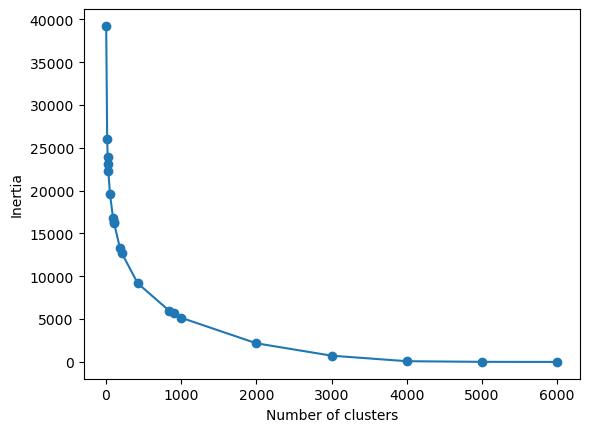

In [22]:
visualizing_inertia_score(ks, inertia_score)

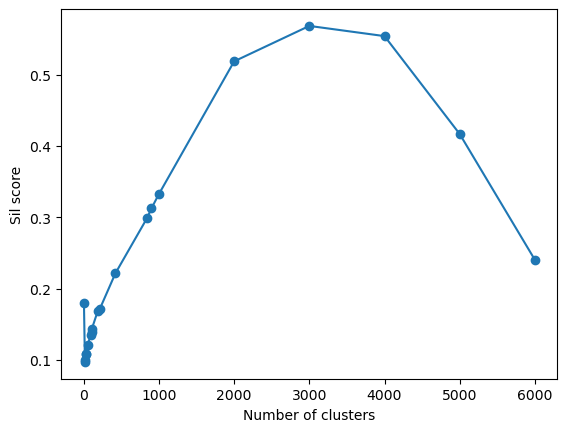

In [23]:
visualizing_silhouette_score(ks, sil_score)

Given the elbow of the inertia score and the peak of the silhouette score, I'd say I'll need 3,000 clusters. 3,000 clusters may make interpretability harder and may make the cluster analysis harder too. So, using backward feature selection, I'll try to determine if the number of clusters can be brought down.

### Drop Make

In [24]:
# Call the function
prefix_to_drop = "Make"
df_for_clustering_makeDropped = drop_feature(df_for_clustering,prefix_to_drop).copy()

**Sanity Check:** see if it dropped all one hot encoded columns for Make (Make had 40 unique values)  
- 95-40 = 55

In [25]:
df_for_clustering_makeDropped.shape

(6951, 55)

In [26]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_makeDropped)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (5897) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [27]:
make_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"makeDropped_").copy()
make_dropped_model_stats

,makeDropped_inertia_score,makeDropped_silhouette_score
n_clusters,,
2,3.264975e+04,0.204115
15,1.993582e+04,0.102986
22,1.842344e+04,0.106381
26,1.762115e+04,0.109864
30,1.696910e+04,0.115086
52,1.481155e+04,0.127704
92,1.250385e+04,0.144421
104,1.206405e+04,0.150495
105,1.200170e+04,0.152369


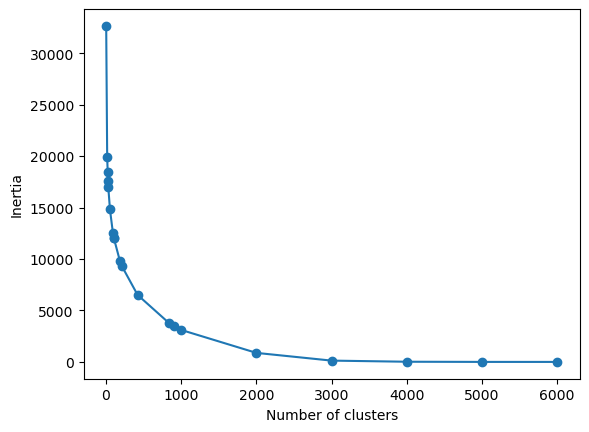

In [28]:
visualizing_inertia_score(ks, inertia_score)

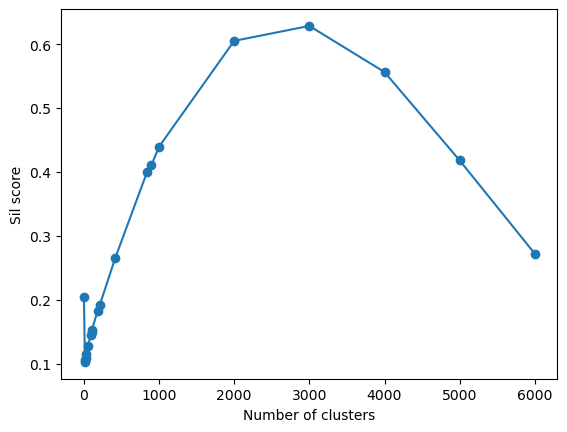

In [29]:
visualizing_silhouette_score(ks, sil_score)

### Drop Transmission Type

In [30]:
# Call the function
prefix_to_drop = "Transmission"
df_for_clustering_transDrop = drop_feature(df_for_clustering_makeDropped,prefix_to_drop).copy()

Sanity Check: see if it dropped all one hot encoded columns for Transmission (Transmission had 26 unique values)  
- 95-40-26 = 29

In [31]:
df_for_clustering_transDrop.shape

(6951, 29)

In [32]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_transDrop)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (5659) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [33]:
transmission_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"transDropped_").copy()
transmission_dropped_model_stats

,transDropped_inertia_score,transDropped_silhouette_score
n_clusters,,
2,2.642114e+04,0.234965
15,1.440162e+04,0.130617
22,1.283851e+04,0.144941
26,1.216764e+04,0.146296
30,1.165882e+04,0.151641
52,9.589026e+03,0.179539
92,7.645160e+03,0.213960
104,7.256795e+03,0.227746
105,7.203054e+03,0.226778


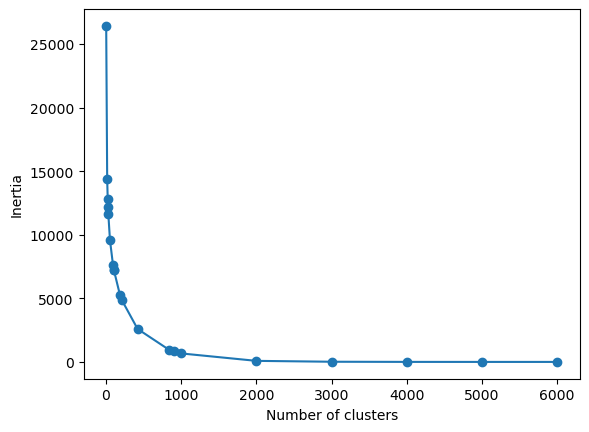

In [34]:
visualizing_inertia_score(ks, inertia_score)

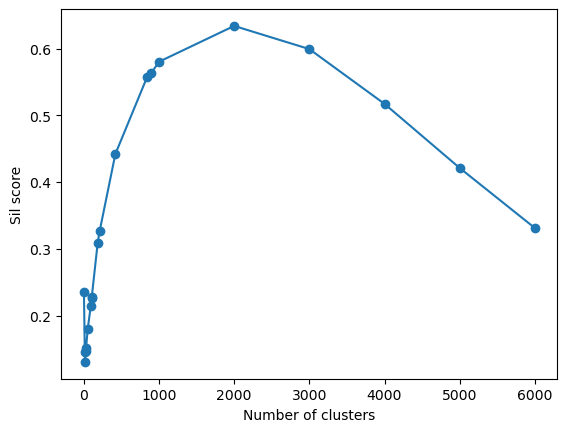

In [35]:
visualizing_silhouette_score(ks, sil_score)

### Drop Fuel Type

In [36]:
# Call the function
prefix_to_drop = "Fuel_Type"
df_for_clustering_fuelDrop = drop_feature(df_for_clustering_transDrop,prefix_to_drop).copy()

Sanity Check: see if it dropped all one hot encoded columns for Fuel_Type (Fuel_Type had 4 unique values)  
- 95-40-26-4 = 25

In [37]:
df_for_clustering_fuelDrop.shape

(6951, 25)

In [38]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_fuelDrop)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000
Running kmeans for k = 4000
Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (5550) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [39]:
fuelType_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"fuelTypeDropped_").copy()
fuelType_dropped_model_stats

,fuelTypeDropped_inertia_score,fuelTypeDropped_silhouette_score
n_clusters,,
2,2.281197e+04,0.253943
15,1.250316e+04,0.131795
22,1.092724e+04,0.158938
26,1.032673e+04,0.159610
30,9.852660e+03,0.157176
52,7.986288e+03,0.192629
92,6.199626e+03,0.253270
104,5.841465e+03,0.266810
105,5.798389e+03,0.265478


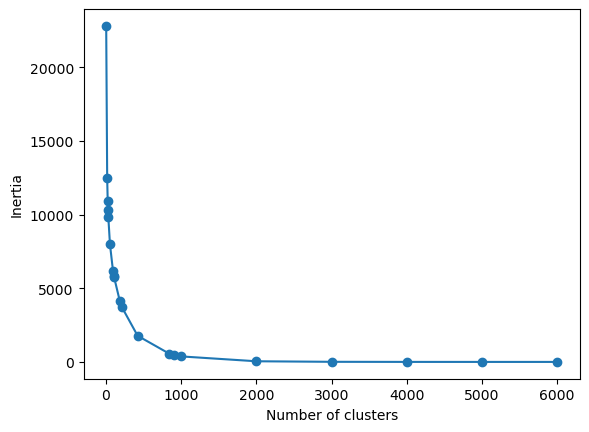

In [40]:
visualizing_inertia_score(ks, inertia_score)

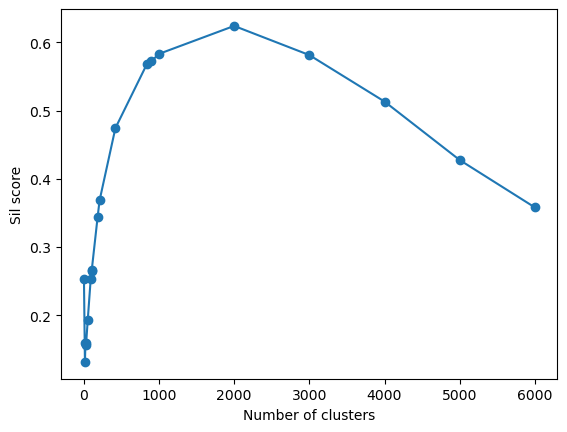

In [41]:
visualizing_silhouette_score(ks, sil_score)

### Drop Model_Year

In [42]:
# Call the function
prefix_to_drop = "Model_Year"
df_for_clustering_modYearDrop = drop_feature(df_for_clustering_fuelDrop,prefix_to_drop).copy()

Sanity Check: see if it dropped all one hot encoded columns for Model_Year (Model_Year had 7 unique values)  
- 95-40-26-4-7 = 18

In [43]:
df_for_clustering_modYearDrop.shape

(6951, 18)

In [44]:
ks, kmeans, y_labels, inertia_score, sil_score = run_modeling(df_for_clustering_modYearDrop)

Running kmeans for k = 2
Running kmeans for k = 15
Running kmeans for k = 22
Running kmeans for k = 26
Running kmeans for k = 30
Running kmeans for k = 52
Running kmeans for k = 92
Running kmeans for k = 104
Running kmeans for k = 105
Running kmeans for k = 184
Running kmeans for k = 210
Running kmeans for k = 420
Running kmeans for k = 840
Running kmeans for k = 900
Running kmeans for k = 1000
Running kmeans for k = 2000
Running kmeans for k = 3000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3499) found smaller than n_clusters (4000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 4000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3499) found smaller than n_clusters (5000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 5000


C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (3499) found smaller than n_clusters (6000). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Running kmeans for k = 6000


In [45]:
modYear_dropped_model_stats = get_model_stats_df(ks, inertia_score, sil_score,"modYear_").copy()
modYear_dropped_model_stats

,modYear_inertia_score,modYear_silhouette_score
n_clusters,,
2,1.687542e+04,0.311707
15,6.792210e+03,0.242399
22,5.565537e+03,0.270127
26,5.015116e+03,0.287651
30,4.533314e+03,0.323765
52,3.013339e+03,0.389601
92,1.654014e+03,0.457089
104,1.441200e+03,0.477809
105,1.426842e+03,0.473972


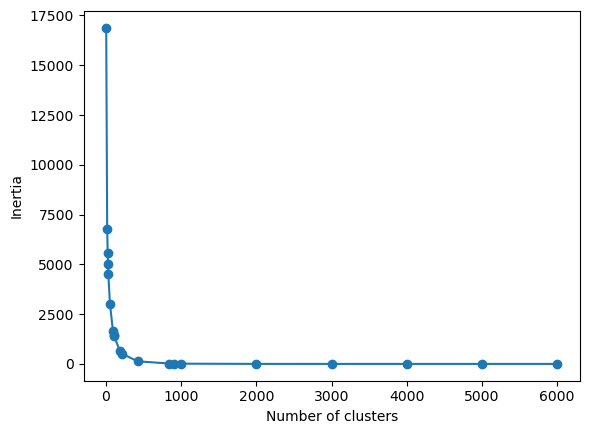

In [46]:
visualizing_inertia_score(ks, inertia_score)

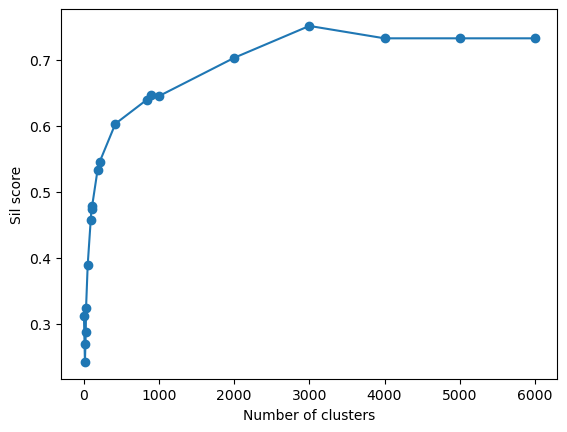

In [47]:
visualizing_silhouette_score(ks, sil_score)

In [53]:
df_for_clustering[df_for_clustering.duplicated()]

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,Model_Year_2017,Model_Year_2018,Model_Year_2019,Model_Year_2020,Model_Year_2021,Model_Year_2022,Model_Year_2023,...,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel_Type_D,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z
10,-0.918953,-0.944729,0.139051,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
31,-0.347160,-0.271860,0.698072,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
42,1.118060,1.237993,0.139051,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
83,-0.668794,-0.682146,1.816113,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
84,-0.668794,-0.682146,1.816113,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,0.224633,0.335364,0.139051,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6851,2.011487,2.206268,-0.978989,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6853,2.047224,2.189857,-0.978989,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6854,2.047224,2.189857,-0.978989,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Investigating the Duplicates Observed During Clustering Warning

In [59]:
filter__ = fuel_cons_rating[fuel_cons_rating.duplicated(keep=False)]
filter__ = filter__.sort_values(by=['Model_Year','Make','Vehicle_Class'])
filter__

,Model_Year,Make,Vehicle_Class,Transmission,Fuel_Type,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
9,2017,ALFA ROMEO,TWO-SEATER,AM6,Z,8.4,197,5
10,2017,ALFA ROMEO,TWO-SEATER,AM6,Z,8.4,197,5
30,2017,AUDI,MID-SIZE,AS8,Z,10.0,238,6
31,2017,AUDI,MID-SIZE,AS8,Z,10.0,238,6
41,2017,AUDI,TWO-SEATER,AM7,Z,14.1,330,5
...,...,...,...,...,...,...,...,...
6854,2023,ROLLS-ROYCE,FULL-SIZE,AS8,Z,16.7,388,3
6855,2023,ROLLS-ROYCE,FULL-SIZE,AS8,Z,17.0,397,3
6856,2023,ROLLS-ROYCE,FULL-SIZE,AS8,Z,17.0,397,3
6850,2023,ROLLS-ROYCE,STATION WAGON - MID-SIZE,AS8,Z,16.6,389,3


In [62]:
original_file = pd.read_csv("fuel_cons_rating_concatenated.csv")
original_file[original_file.duplicated()]

,Unnamed: 0,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),Fuel_Consumption-Comb(mpg),CO2_Emissions(g/km),CO2_Rating,Smog_Rating


**Observation**  
As you can see the original data doesnt have any duplicates.The we observe here are due to dropping certain columns that make them appear same. So, I won't be removing any "duplicated" rows that resulted from backward feature selection. Because I want the labels from the model to concatenate to the dataframe.

## Joining Model Stats DataFrames for Feature Selection

In [48]:
stats_joined_df = main_model_stats_df.join([make_dropped_model_stats, transmission_dropped_model_stats, fuelType_dropped_model_stats,modYear_dropped_model_stats], how='inner')
stats_joined_df

,inertia_score,silhouette_score,makeDropped_inertia_score,makeDropped_silhouette_score,transDropped_inertia_score,transDropped_silhouette_score,fuelTypeDropped_inertia_score,fuelTypeDropped_silhouette_score,modYear_inertia_score,modYear_silhouette_score
n_clusters,,,,,,,,,,
2,39233.279591,0.179586,3.264975e+04,0.204115,2.642114e+04,0.234965,2.281197e+04,0.253943,1.687542e+04,0.311707
15,25995.715406,0.096932,1.993582e+04,0.102986,1.440162e+04,0.130617,1.250316e+04,0.131795,6.792210e+03,0.242399
22,23944.976750,0.099568,1.842344e+04,0.106381,1.283851e+04,0.144941,1.092724e+04,0.158938,5.565537e+03,0.270127
26,23129.218128,0.107433,1.762115e+04,0.109864,1.216764e+04,0.146296,1.032673e+04,0.159610,5.015116e+03,0.287651
30,22291.858599,0.108134,1.696910e+04,0.115086,1.165882e+04,0.151641,9.852660e+03,0.157176,4.533314e+03,0.323765
52,19652.739800,0.121304,1.481155e+04,0.127704,9.589026e+03,0.179539,7.986288e+03,0.192629,3.013339e+03,0.389601
92,16856.084821,0.134721,1.250385e+04,0.144421,7.645160e+03,0.213960,6.199626e+03,0.253270,1.654014e+03,0.457089
104,16327.400013,0.138754,1.206405e+04,0.150495,7.256795e+03,0.227746,5.841465e+03,0.266810,1.441200e+03,0.477809
105,16269.813524,0.142657,1.200170e+04,0.152369,7.203054e+03,0.226778,5.798389e+03,0.265478,1.426842e+03,0.473972


In the main dataframe, the elbow point in inertia score is not as prominent, so looking at the silhouette score, it seems having 3,000 clusters is the best solution here(inertia score = 730.9 and silhouette score = 0.57). However, it is not practical nor meaningful for the purpose of my project.  
I observe that as the features drop inertia and silhouette scores improve for smaller number of clusters. In the last one, where 4 columns have been dropped leaving only Vehicle_Class, Fuel_Consumption, CO2_Emissions, and Smog_Rating columns, I have much better score for inertia and silhouette score at 420 clusters which is a lot more practical and may serve well. Inertia score at this point is 130 and silhouette is 0.6 which is way better than main dataframe used for clustering.  
**It seems that my experiment in Sprint 2 with just these columns was the right choice** Moving forward with DBScan, I'd like to use these features.

# Advanced Modelling
## Baseline DBScan Model
DBScan has 2 very important hyperparameters:
- eps
    - radius of the cluster in other words farthest distance to a data point from the center
- min_samples
    - min number of data points to be considered a cluster  
  
I was researching how to best come up with min_samples and eps values. I found that we can start with ln(n_data_points) for min_samples. Given that the original data frame has 6,951 rows, I'll try ln(6951) = 8.845, so I'll try 9 as min_samples for the baseline, and later try values around this number for fine tuning the model. As for eps value, I read that it is better to do K-nearest_neighbour analysis, so I'll do that first. https://askdatascience.com/646/dbscan-algorithm-how-should-choose-optimal-minimum-points  
I looked into it further to determin what value to choose for the n-neighbours and found that n = 2*(number of columns) in the dataset. Now what I am not sure about is whether this N in 2xN is for columns before or after feature selection. So, I'll experiment with both. https://caveofpython.com/machine-learning/nearest-neighbours/  


In [65]:
df_for_clustering_modYearDrop.columns.to_list()

['Fuel_Consumption-Comb(L/100 km)',
 'CO2_Emissions(g/km)',
 'Smog_Rating',
 'Vehicle_Class_COMPACT',
 'Vehicle_Class_FULL-SIZE',
 'Vehicle_Class_MID-SIZE',
 'Vehicle_Class_MINICOMPACT',
 'Vehicle_Class_MINIVAN',
 'Vehicle_Class_PICKUP TRUCK - SMALL',
 'Vehicle_Class_PICKUP TRUCK - STANDARD',
 'Vehicle_Class_SPECIAL PURPOSE VEHICLE',
 'Vehicle_Class_STATION WAGON - MID-SIZE',
 'Vehicle_Class_STATION WAGON - SMALL',
 'Vehicle_Class_SUBCOMPACT',
 'Vehicle_Class_SUV - SMALL',
 'Vehicle_Class_SUV - STANDARD',
 'Vehicle_Class_TWO-SEATER',
 'Vehicle_Class_VAN - PASSENGER']

In [64]:
len(df_for_clustering_modYearDrop.columns)

18

### Determining optimal eps Value using KNN

2x18 = 36, so I'll need 36 n_neighbours 

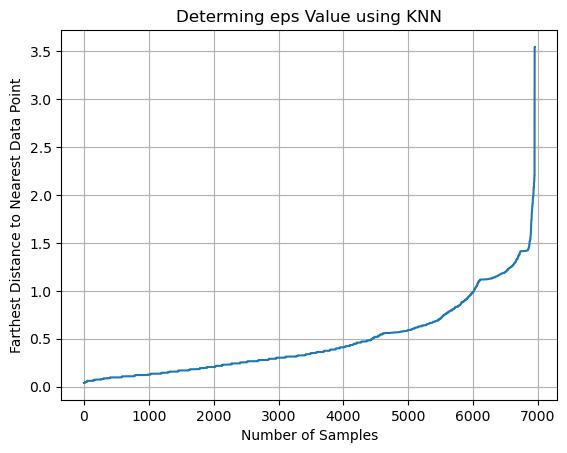

In [66]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=36)
nn.fit(df_for_clustering_modYearDrop)

distances, indices = nn.kneighbors()
sorted_distances = np.sort(distances, axis=0)

# chose 35th column because it has the farthest distance and eps is about farthest distance
plt.plot(sorted_distances[:,35])
plt.xlabel('Number of Samples')
plt.ylabel('Farthest Distance to Nearest Data Point')
plt.title('Determing eps Value using KNN')
plt.grid(True)
plt.show()

In [69]:
sorted_distances[:,35]

array([0.03932523, 0.03932523, 0.03932523, ..., 3.54635061, 3.54635061,
       3.54635061])

I read that eps value should be chosen based on where you see the elbow in this graph. So, based on this, I choose eps value of 0.5 for DBScan baseline model.
### Baseline Modeling

In [70]:
from sklearn.cluster import DBSCAN

# Instantiate
dbscan_model = DBSCAN(eps=0.5, min_samples=9)

# Fit and get labels
cluster_labels = dbscan_model.fit_predict(df_for_clustering_modYearDrop)

In [73]:
# Check cluster labels
result = np.unique(cluster_labels, return_counts=True)
unique_labels = result[0]
count = result[1]
pd.DataFrame({'Cluster Label': unique_labels, 'Count': count})

,Cluster Label,Count
0,-1,394
1,0,149
2,1,262
3,2,25
4,3,123
...,...,...
77,76,86
78,77,7
79,78,9
80,79,9


In [74]:
# Find non-noise points
non_noise = cluster_labels[cluster_labels != -1]
# Get number of clusters
n_cluster = len(np.unique(non_noise))
print("This baseline DBScan model came up with ",n_cluster," clusters")

This baseline DBScan model came up with  81  clusters


In [75]:
# Get silhouette score
silhouette = silhouette_score(df_for_clustering_modYearDrop, cluster_labels)
print(silhouette)

0.21747471296066676


Although I did my best to select best possible value for min_sample and eps for the baseline model, it's silhouette score is note even close to the ideal silhouette score (closer to 1). So, it's time to hypertune the parameters.

## Hyperparameters Tuning
During my reflection piece, I had a light bulb moment that perhaps the only features I ever needed were Fuel consumption, co2 emissions and smog rating. So, now I am turing everything I had into a function so I can try it for the new data frame, so I can reuse this code.

In [115]:
def dbscan_tuning(df):   
    # Instantiate an empty list of results
    results = []
    eps= [0.1, 0.23, 0.5, 0.75, 1.0, 1.5, 2]
    min_samples = [1, 3, 6, 9, 12, 15, 18]
    # Iterate over eps and min samples
    for e in eps:
        for m in min_samples:
            # Instantiate
            dbscan_model = DBSCAN(eps=e, min_samples=m)

            # Fit
            cluster_labels = dbscan_model.fit_predict(df)

            # Find non-noise points
            non_noise = cluster_labels[cluster_labels != -1]

            # Get silhouette score and number of clusters
            n_cluster = len(np.unique(non_noise))

            if n_cluster > 1:
                silhouette = silhouette_score(df, cluster_labels)
            else:
                silhouette = np.NaN

            # Append to list
            results.append((e, m, n_cluster, silhouette))
            print(f"Running DBScan for eps = {e} and min_samples = {m}")
    #creating a result dataframe so I can see what eps, min_samples yield better silhouette score and how may clusters it generated
    results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'silhouette_score'])
    return results_df

In [117]:
results_df = dbscan_tuning(df_for_clustering_modYearDrop).copy()

Running DBScan for eps = 0.1 and min_samples = 1
Running DBScan for eps = 0.1 and min_samples = 3
Running DBScan for eps = 0.1 and min_samples = 6
Running DBScan for eps = 0.1 and min_samples = 9
Running DBScan for eps = 0.1 and min_samples = 12
Running DBScan for eps = 0.1 and min_samples = 15
Running DBScan for eps = 0.1 and min_samples = 18
Running DBScan for eps = 0.23 and min_samples = 1
Running DBScan for eps = 0.23 and min_samples = 3
Running DBScan for eps = 0.23 and min_samples = 6
Running DBScan for eps = 0.23 and min_samples = 9
Running DBScan for eps = 0.23 and min_samples = 12
Running DBScan for eps = 0.23 and min_samples = 15
Running DBScan for eps = 0.23 and min_samples = 18
Running DBScan for eps = 0.5 and min_samples = 1
Running DBScan for eps = 0.5 and min_samples = 3
Running DBScan for eps = 0.5 and min_samples = 6
Running DBScan for eps = 0.5 and min_samples = 9
Running DBScan for eps = 0.5 and min_samples = 12
Running DBScan for eps = 0.5 and min_samples = 15
Runni

In [118]:
results_df

,eps,min_samples,n_clusters,silhouette_score
0,0.10,1,771,0.356869
1,0.10,3,364,0.340101
2,0.10,6,211,0.247728
3,0.10,9,143,0.146889
4,0.10,12,104,0.068482
5,0.10,15,86,0.001944
6,0.10,18,61,-0.124110
7,0.23,1,390,0.216404
8,0.23,3,206,0.262531
9,0.23,6,129,0.257395


So, DBScan is a winner! At epsilon value of 1.5 and min_samples value of 15 I am able to get 2 clusters! And guess what! 2 clusters is what I need to becuase I am trying to determine whether the vehicles are green or not green. And by clustering the vehicle in 2 clusters it has done me a HUGE favor! I had been agonozing over how I will analyze 420 clusters to label as green or not green. AH DBSCAN is such a saviour. I'd say this is because DBScan doesn't just cluster is a circular way it is able to pick up other patherns of clusters too. Something KMeans algorithm can't do. 

## Final Modelling Based on Hyperparameters Tuning

In [135]:
def dbscan_modeling_label(df,eps,min_samples):
    # Instantiate
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    # Fit and get labels
    cluster_labels = dbscan_model.fit_predict(df)
    # Check cluster labels
    result = np.unique(cluster_labels, return_counts=True)
    unique_labels = result[0]
    count = result[1]
    return pd.DataFrame({'Cluster Label': unique_labels, 'Count': count}), cluster_labels

In [136]:
label_count_df, cluster_labels = dbscan_modeling_label(df_for_clustering_modYearDrop,1.5,12)
label_count_df

,Cluster Label,Count
0,-1,16
1,0,6906
2,1,29


In [137]:
# sanity check to see if i got my labels
np.unique(cluster_labels)

array([-1,  0,  1], dtype=int64)

In [138]:
def concatenate_cluster_labels(df,cluster_labels):
    df_new = df.copy()
    df_new["DBScan_cluster_lables"] = cluster_labels
    return df_new

In [139]:
df_after_clustering = concatenate_cluster_labels(df_for_clustering_modYearDrop,cluster_labels).copy()
df_after_clustering.head()

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,Vehicle_Class_COMPACT,Vehicle_Class_FULL-SIZE,Vehicle_Class_MID-SIZE,Vehicle_Class_MINICOMPACT,Vehicle_Class_MINIVAN,Vehicle_Class_PICKUP TRUCK - SMALL,Vehicle_Class_PICKUP TRUCK - STANDARD,Vehicle_Class_SPECIAL PURPOSE VEHICLE,Vehicle_Class_STATION WAGON - MID-SIZE,Vehicle_Class_STATION WAGON - SMALL,Vehicle_Class_SUBCOMPACT,Vehicle_Class_SUV - SMALL,Vehicle_Class_SUV - STANDARD,Vehicle_Class_TWO-SEATER,Vehicle_Class_VAN - PASSENGER,DBScan_cluster_lables
0,-0.990427,-1.026786,0.698072,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.010211,0.072781,0.698072,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.097001,-0.058511,0.698072,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,-0.704531,-0.731380,0.698072,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.010211,0.105604,0.698072,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Visualizing the Clusters
Because I have 18 features, I'll need to perform dimensionality reduction using t-SNE in order to visualize my clusters.

In [140]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=1)
tsne_data = tsne.fit_transform(df_after_clustering.drop(['DBScan_cluster_lables'], axis=1))

tsne_dbscan_df = pd.DataFrame(tsne_data, columns=[f'D{i+1}' for i in range(3)])
tsne_dbscan_df['DBScan_cluster_lables'] = df_after_clustering['DBScan_cluster_lables'].values
tsne_dbscan_df.shape

C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sundus Yawar\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(6951, 4)

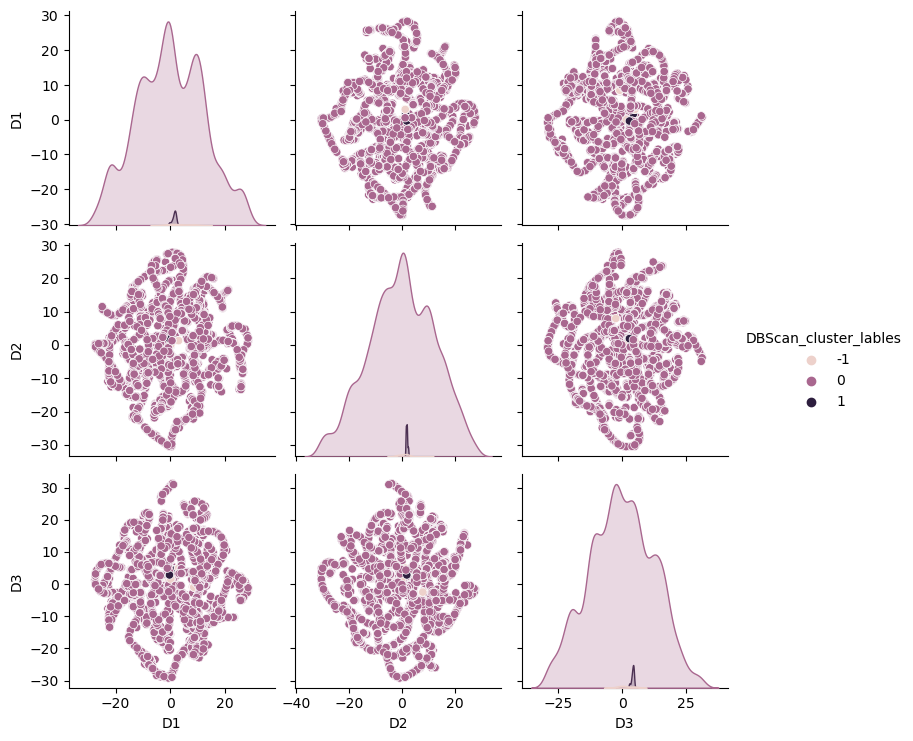

In [141]:
sns.pairplot(tsne_dbscan_df, hue='DBScan_cluster_lables')
plt.show()

### Analyzing the Clusters to Determine Legitimacy of the Formed Clusters and Deriving Insights

In [142]:
def analyze_dbscan_cluster(df):
    # allows me to specify 3 columns to aggregate and how (i.e. median in my case)
    agg_functions = {
        'Fuel_Consumption-Comb(L/100 km)': 'median',
        'CO2_Emissions(g/km)': 'median',
        'Smog_Rating': 'median'
    }
    # now use this aggregation function in group by statement
    #group by cluster label so I can analyze the clusters
    grp_by_dbscanLabels_median = df.groupby('DBScan_cluster_lables').agg(agg_functions).reset_index()
    # Since index to DBScan_cluster_labels for my convinience, it just visually looks easier to read.
    grp_by_dbscanLabels_median.set_index('DBScan_cluster_lables', inplace=True)
    return grp_by_dbscanLabels_median
    

In [143]:
analyze_dbscan_cluster(df_after_clustering)


,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
DBScan_cluster_lables,,,
-1,3.172942,3.125309,-2.097030
0,-0.132738,-0.091334,0.139051
1,4.012763,4.274110,-2.097030


In [144]:
# Get silhouette score
silhouette = silhouette_score(df_for_clustering_modYearDrop, cluster_labels)
print(silhouette)

0.5395385745182943


#### Result of the Cluster Analysis
Even though an imbalance was observed in the clusters, based on my analysis, the clustering is done correctly. 
| Cluster Label | Count |
|---------------|-------|
| -1            | 16    |
| 0             | 6906  |
| 1             | 29    |  
  
The cluster label -1 represents outliers. Cluster labels 0 and 1 are the actual clusters.  
**What does it mean for a vehicle to be green?**  
- Recall: Smog Rating had values ranging from 1 to 10, where 1 meant worst and 10 meant best. However, you see decimal values for Smog rating right now due to Standard Scaling performed on these 3 numeric columns for the purpose of modelling.
- Green means having:
    - low fuel consumption
    - low CO2 emissions
    - high Smog rating  
      
**Do these clusters adhere to the definition of green vehicle?**  
- Cluster 0:
    - Has low values for Fuel consumption and CO2 emissions and high value for Smog rating
        - This indicates that vehicles in this clusters are green based on our definition of green
- Cluster 1:
    - Has high values for Fuel consumption and CO2 emissions and low value for Smog rating
        - This indicates that vehicles in this clusters are NOT green based on our definition of green  
  
Therefore, the clustering performed by DBScan seems legitimate as it adheres to the definition of what is green and isn't green. 
  
#### Reflection
Initially, I was expecting many clusters because based on my analysis in Sprint 1, a lot of factors affected whether a vehicle will be green or not green. These included Year, Make and Vehicle class. So, I was expecting that I'll have several clusters because across makes I observed that one Make was indeed more greener than another. And that what's considered fuel efficient, and low CO2 emissions and better Smog rating would differ across vehicle types. Because SUV is heavier than a mini compact vehicle so what's fuel efficient for that is going to be different for what's fuel efficient for a mini compact car. And while all this does make sense and is supported by EDA in Sprint 1. Having 2 clusters makes sense because at the end of the day we are classifying all those vehicles as green or not green. So, if we really think about it, all we really needed for this classification were 3 features only, fuel consumption, co2 emissions and smog rating. 


##### Testing Insight Derived from Reflection in the Final Model 
I just want to know if I use fuel consumption, co2 emissions and smog rating features only, if I can get better silhouette score and better clustering

In [131]:
# Call the function
prefix_to_drop = "Vehicle_Class"
df_for_clustering_vehicleClassDrop = drop_feature(df_for_clustering_modYearDrop,prefix_to_drop).copy()

In [132]:
#sanity check, should see only 3 as column size
df_for_clustering_vehicleClassDrop.shape

(6951, 3)

In [133]:
# trying diff eps and min_samples to find optimal values for this new data frame
results_df = dbscan_tuning(df_for_clustering_vehicleClassDrop).copy()

Running DBScan for eps = 0.1 and min_samples = 1
Running DBScan for eps = 0.1 and min_samples = 3
Running DBScan for eps = 0.1 and min_samples = 6
Running DBScan for eps = 0.1 and min_samples = 9
Running DBScan for eps = 0.1 and min_samples = 12
Running DBScan for eps = 0.1 and min_samples = 15
Running DBScan for eps = 0.1 and min_samples = 18
Running DBScan for eps = 0.23 and min_samples = 1
Running DBScan for eps = 0.23 and min_samples = 3
Running DBScan for eps = 0.23 and min_samples = 6
Running DBScan for eps = 0.23 and min_samples = 9
Running DBScan for eps = 0.23 and min_samples = 12
Running DBScan for eps = 0.23 and min_samples = 15
Running DBScan for eps = 0.23 and min_samples = 18
Running DBScan for eps = 0.5 and min_samples = 1
Running DBScan for eps = 0.5 and min_samples = 3
Running DBScan for eps = 0.5 and min_samples = 6
Running DBScan for eps = 0.5 and min_samples = 9
Running DBScan for eps = 0.5 and min_samples = 12
Running DBScan for eps = 0.5 and min_samples = 15
Runni

In [134]:
results_df

,eps,min_samples,n_clusters,silhouette_score
0,0.10,1,156,-0.477620
1,0.10,3,60,-0.271908
2,0.10,6,35,-0.132765
3,0.10,9,23,-0.084263
4,0.10,12,22,-0.070767
5,0.10,15,21,-0.078572
6,0.10,18,20,-0.085375
7,0.23,1,70,-0.407701
8,0.23,3,39,-0.267472
9,0.23,6,26,-0.126307


WOW my hunch was right that it all really just comes down to these 3 features to determine whether a vehicle is green or not. Sorry, I can't contain my excitement! Anyway, as you can see I got the highest silhouette score of 0.73 with this, which is the highest I have gotten in experiments thus far. The eps value remains the same, however, now min_sample is 1 and it still yields 2 clusters. This is amazing!    

**Build the Final DBScan Model Based on the Optimal Values Determined from the Above Experiment**

In [145]:
label_count_df, cluster_labels = dbscan_modeling_label(df_for_clustering_vehicleClassDrop,1.5,1)

In [146]:
label_count_df

,Cluster Label,Count
0,0,6946
1,1,5


This time there is no noise in the cluster. That is quite wonderful! And it seems like most of the vehicles in the dataset are green.    

**Concatenate Cluster labels**

In [148]:
df_after_clustering = concatenate_cluster_labels(df_for_clustering_vehicleClassDrop, cluster_labels)
# sanity check to see if cluster labels got concatenated to the df or not
df_after_clustering.head()

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,DBScan_cluster_lables
0,-0.990427,-1.026786,0.698072,0
1,0.010211,0.072781,0.698072,0
2,-0.097001,-0.058511,0.698072,0
3,-0.704531,-0.731380,0.698072,0
4,0.010211,0.105604,0.698072,0


In [149]:
#Analyze the clusters
analyze_dbscan_cluster(df_after_clustering)

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
DBScan_cluster_lables,,,
0,-0.132738,-0.074922,0.139051
1,5.406509,5.800374,-2.097030


**Cluster 0** adheres to the definition of what it means to be green as fuel consumption and CO2 emissions are low and Smog rating is high.  
**Cluster 1** also adheres to that definition, and indicates that it contains NON-green vehicles, as this cluster contains vehicles with high fuel consumption and CO2 emissions values and low Smog Rating values.

**Time to visualize these clusters.** And since this time we only have 3 features I don't need to perform dimensionality reduction technique like t-SNE to visualize my clusters. (I just want to see the birds eye view as well, so I'll put this into function.

In [248]:
def visualize_dbscan_clusters(e,a,df):
    # Separate data by cluster label
    green_df = df[df['DBScan_cluster_lables'] == 0]
    not_green_df = df[df['DBScan_cluster_lables'] == 1]

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for Cluster 1
    ax.scatter(green_df['Fuel_Consumption-Comb(L/100 km)'], green_df['CO2_Emissions(g/km)'], green_df['Smog_Rating'], c='g', marker='o', label='Green')

    # Scatter plot for Cluster 2
    ax.scatter(not_green_df['Fuel_Consumption-Comb(L/100 km)'], not_green_df['CO2_Emissions(g/km)'], not_green_df['Smog_Rating'], c='r', marker='o', label='NOT Green')

    # Customize the plot (labels, titles, etc.)
    ax.set_xlabel('Fuel_Consumption-Comb(L/100 km)')
    ax.set_ylabel('CO2_Emissions(g/km)')
    ax.set_zlabel('Smog_Rating')
    plt.title('3D DBScan Clusters Visualization')

    # I want to adjust the graph so I can see the cluster separation properly hence trying to tilt
    ax.view_init(elev=e, azim=a)

    plt.legend()
    plt.show()

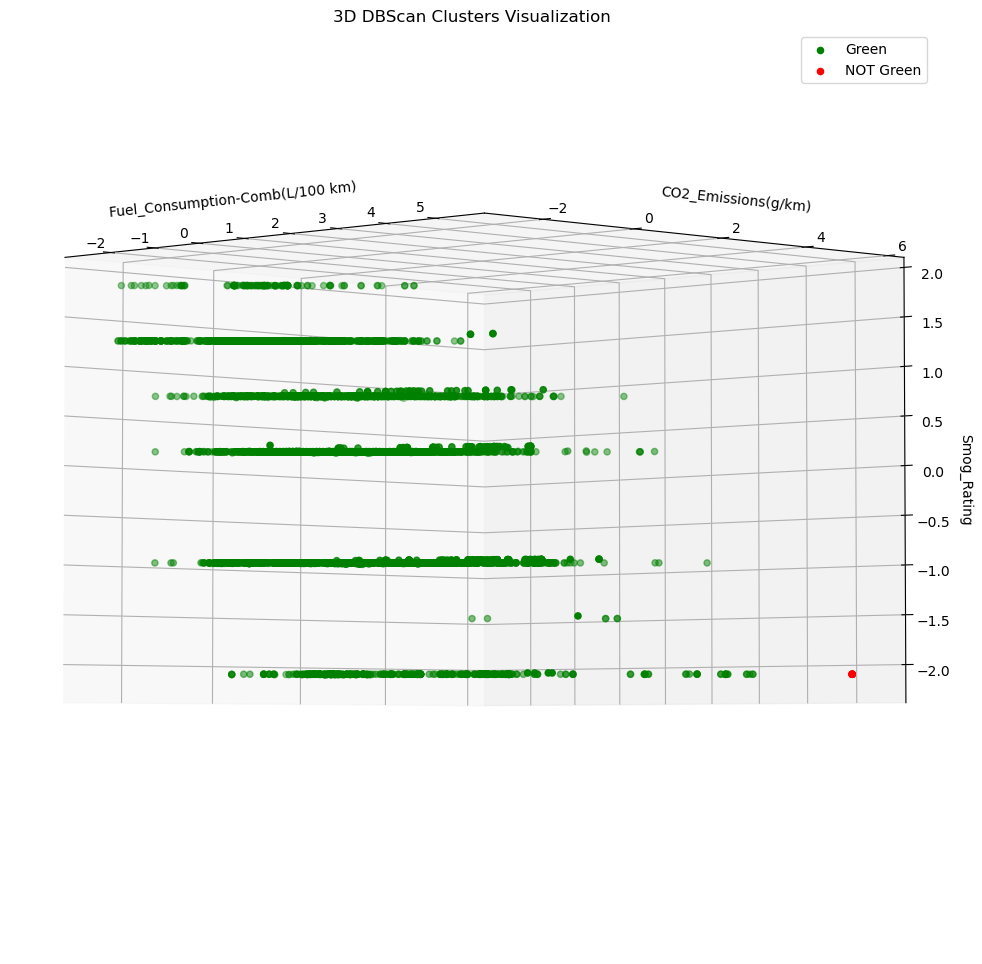

In [249]:
# values are based on experimentation
visualize_dbscan_clusters(-3,-45,df_after_clustering)

I feel like it could have done a better job in clustering. It makes sense for the data above 0 point for smog rating to be considered as green but not for the ones below that as the ones below also have higher CO2 and fuel consumption. I'd like to try modelling again and between values 1 and 1.5. 
| eps  | min_samples | clusters | silhouette_score |
|------|-------------|----------|------------------|
| 1.00 | 1           | 4        | 0.260595         |
| 1.00 | 3           | 3        | 0.260595         |
| 1.00 | 6           | 2        | 0.362850         |
| 1.00 | 9           | 2        | 0.362447         |
| 1.00 | 12          | 2        | 0.362447         |
| 1.00 | 15          | 2        | 0.362447         |
| 1.00 | 18          | 2        | 0.362356         |
| 1.50 | 1           | 2        | 0.728766         |
| 1.50 | 3           | 2        | 0.728766         |
| 1.50 | 6           | 1        | NaN              |

I am just curious to know what the bird-eye view would look like for this cluster So, I'll experiment with the elevation and azimuth values.

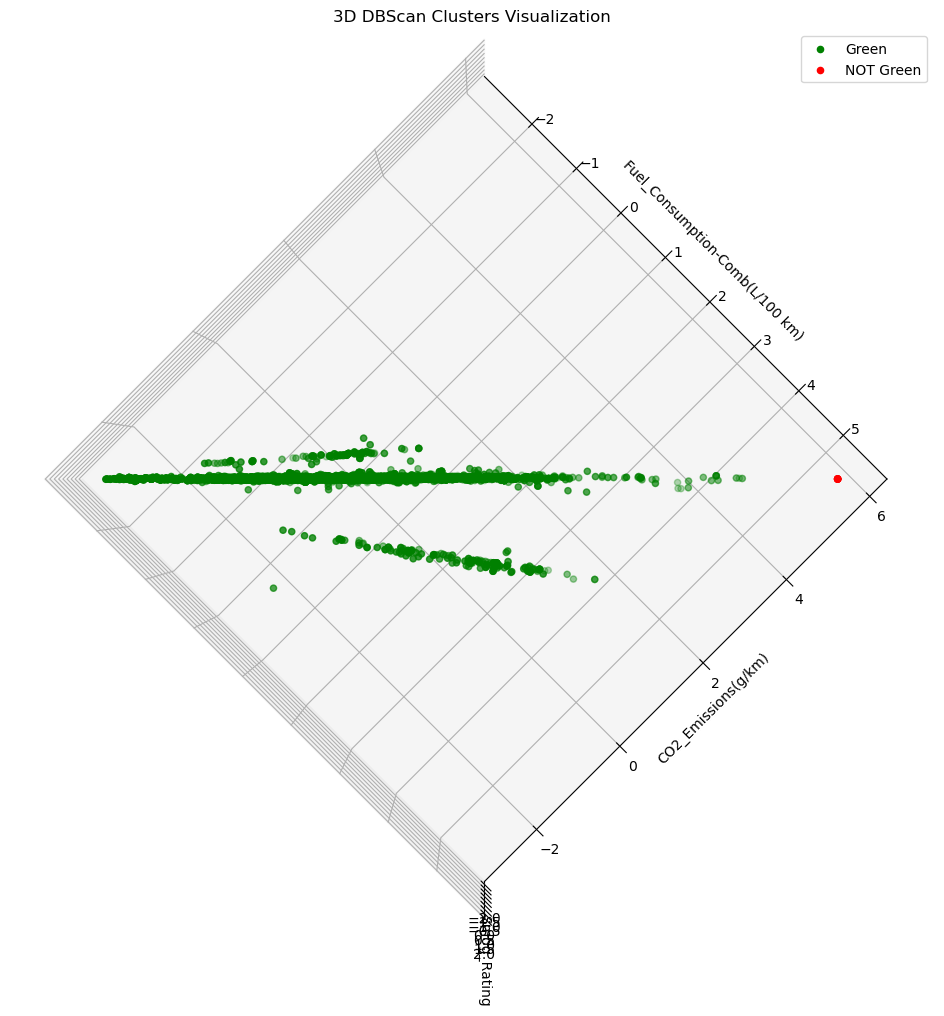

In [250]:
#values for elevation and azimuth are based on experimentation
visualize_dbscan_clusters(90,-50,df_after_clustering)

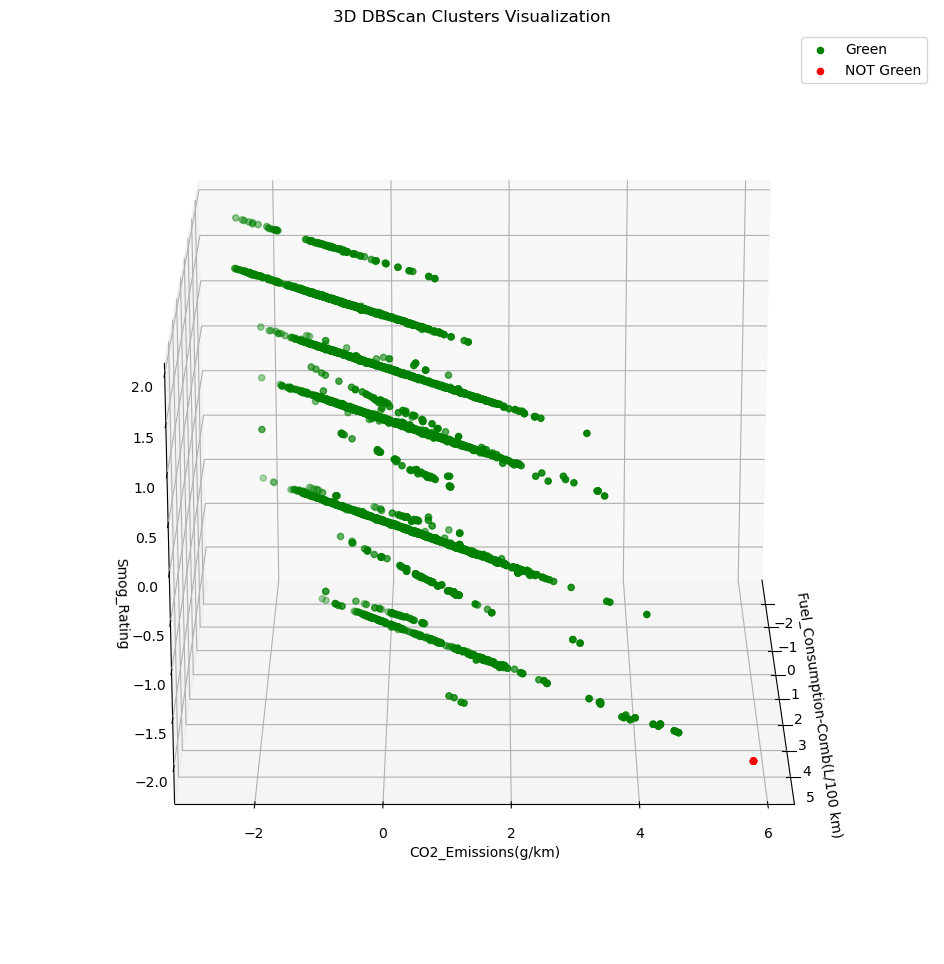

In [258]:
visualize_dbscan_clusters(20,0,df_after_clustering)

###### Refining modelling 

In [235]:
def dbscan_tuning_v2(df,eps,min_samples):   
    # Instantiate an empty list of results
    results = []
    
    # Iterate over eps and min samples
    for e in eps:
        for m in min_samples:
            # Instantiate
            dbscan_model = DBSCAN(eps=e, min_samples=m)

            # Fit
            cluster_labels = dbscan_model.fit_predict(df)

            # Find non-noise points
            non_noise = cluster_labels[cluster_labels != -1]

            # Get silhouette score and number of clusters
            n_cluster = len(np.unique(non_noise))

            if n_cluster > 1:
                silhouette = silhouette_score(df, cluster_labels)
            else:
                silhouette = np.NaN

            # Append to list
            results.append((e, m, n_cluster, silhouette))
            print(f"Running DBScan for eps = {e} and min_samples = {m}")
    #creating a result dataframe so I can see what eps, min_samples yield better silhouette score and how may clusters it generated
    results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'silhouette_score'])
    return results_df

In [236]:
eps= [1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
min_samples = [1, 3, 6, 9, 12, 15, 18]
results_df_v2 = dbscan_tuning_v2(df_for_clustering_vehicleClassDrop,eps,min_samples)

Running DBScan for eps = 1.0 and min_samples = 1
Running DBScan for eps = 1.0 and min_samples = 3
Running DBScan for eps = 1.0 and min_samples = 6
Running DBScan for eps = 1.0 and min_samples = 9
Running DBScan for eps = 1.0 and min_samples = 12
Running DBScan for eps = 1.0 and min_samples = 15
Running DBScan for eps = 1.0 and min_samples = 18
Running DBScan for eps = 1.05 and min_samples = 1
Running DBScan for eps = 1.05 and min_samples = 3
Running DBScan for eps = 1.05 and min_samples = 6
Running DBScan for eps = 1.05 and min_samples = 9
Running DBScan for eps = 1.05 and min_samples = 12
Running DBScan for eps = 1.05 and min_samples = 15
Running DBScan for eps = 1.05 and min_samples = 18
Running DBScan for eps = 1.1 and min_samples = 1
Running DBScan for eps = 1.1 and min_samples = 3
Running DBScan for eps = 1.1 and min_samples = 6
Running DBScan for eps = 1.1 and min_samples = 9
Running DBScan for eps = 1.1 and min_samples = 12
Running DBScan for eps = 1.1 and min_samples = 15
Runni

In [237]:
results_df_v2[results_df_v2['silhouette_score']>=0.5]

,eps,min_samples,n_clusters,silhouette_score
21,1.15,1,2,0.728766
22,1.15,3,2,0.728766
28,1.20,1,2,0.728766
29,1.20,3,2,0.728766
35,1.25,1,2,0.728766
36,1.25,3,2,0.728766
42,1.30,1,2,0.728766
43,1.30,3,2,0.728766
49,1.35,1,2,0.728766
50,1.35,3,2,0.728766


In [239]:
results_df_v2[(results_df_v2['n_clusters']==2) & (results_df_v2['silhouette_score']>=0.3) & (results_df_v2['silhouette_score']<=0.7)]

,eps,min_samples,n_clusters,silhouette_score
2,1.00,6,2,0.362850
3,1.00,9,2,0.362447
4,1.00,12,2,0.362447
5,1.00,15,2,0.362447
6,1.00,18,2,0.362356
9,1.05,6,2,0.362850
10,1.05,9,2,0.362447
11,1.05,12,2,0.362447
12,1.05,15,2,0.362447
13,1.05,18,2,0.362447


In [240]:
eps= [0.76,0.77,0.78,0.80,0.83,0.86,0.89,0.92,0.95,0.98,1.0, 1.05, 1.1, 1.15]
min_samples = [1, 2, 4, 6, 8,10, 12]
results_df_v2 = dbscan_tuning_v2(df_for_clustering_vehicleClassDrop,eps,min_samples)

Running DBScan for eps = 0.76 and min_samples = 1
Running DBScan for eps = 0.76 and min_samples = 2
Running DBScan for eps = 0.76 and min_samples = 4
Running DBScan for eps = 0.76 and min_samples = 6
Running DBScan for eps = 0.76 and min_samples = 8
Running DBScan for eps = 0.76 and min_samples = 10
Running DBScan for eps = 0.76 and min_samples = 12
Running DBScan for eps = 0.77 and min_samples = 1
Running DBScan for eps = 0.77 and min_samples = 2
Running DBScan for eps = 0.77 and min_samples = 4
Running DBScan for eps = 0.77 and min_samples = 6
Running DBScan for eps = 0.77 and min_samples = 8
Running DBScan for eps = 0.77 and min_samples = 10
Running DBScan for eps = 0.77 and min_samples = 12
Running DBScan for eps = 0.78 and min_samples = 1
Running DBScan for eps = 0.78 and min_samples = 2
Running DBScan for eps = 0.78 and min_samples = 4
Running DBScan for eps = 0.78 and min_samples = 6
Running DBScan for eps = 0.78 and min_samples = 8
Running DBScan for eps = 0.78 and min_samples 

In [241]:
results_df_v2[results_df_v2['silhouette_score']>=0.5]

,eps,min_samples,n_clusters,silhouette_score
91,1.15,1,2,0.728766
92,1.15,2,2,0.728766
93,1.15,4,2,0.728766


In [242]:
results_df_v2[(results_df_v2['n_clusters']==2) & (results_df_v2['silhouette_score']>=0.3) & (results_df_v2['silhouette_score']<=0.7)]

,eps,min_samples,n_clusters,silhouette_score
52,0.92,6,2,0.362433
53,0.92,8,2,0.362056
54,0.92,10,2,0.362056
59,0.95,6,2,0.362433
60,0.95,8,2,0.362056
61,0.95,10,2,0.362056
62,0.95,12,2,0.362056
66,0.98,6,2,0.362850
67,0.98,8,2,0.362850
68,0.98,10,2,0.362447


**Build the Final DBScan Model Based on the Optimal Values Determined from the Above Experiment**

In [243]:
label_count_df_v2, cluster_labels_v2 = dbscan_modeling_label(df_for_clustering_vehicleClassDrop,0.98,6)

In [244]:
label_count_df_v2

,Cluster Label,Count
0,-1,6
1,0,4632
2,1,2313


This time there is no noise in the cluster. That is quite wonderful! And it seems like most of the vehicles in the dataset are green.    

**Concatenate Cluster labels**

In [252]:
df_after_clustering_v2 = concatenate_cluster_labels(df_for_clustering_vehicleClassDrop, cluster_labels_v2)
# sanity check to see if cluster labels got concatenated to the df or not
df_after_clustering_v2.head()

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating,DBScan_cluster_lables
0,-0.990427,-1.026786,0.698072,0
1,0.010211,0.072781,0.698072,0
2,-0.097001,-0.058511,0.698072,0
3,-0.704531,-0.731380,0.698072,0
4,0.010211,0.105604,0.698072,0


In [253]:
#Analyze the clusters
analyze_dbscan_cluster(df_after_clustering_v2)

,Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),Smog_Rating
DBScan_cluster_lables,,,
-1,5.406509,5.800374,-2.097030
0,-0.311423,-0.296477,0.698072
1,0.403318,0.450244,-0.978989


**Cluster 0** adheres to the definition of what it means to be green as fuel consumption and CO2 emissions are low and Smog rating is high.  
**Cluster 1** also adheres to that definition, and indicates that it contains NON-green vehicles, as this cluster contains vehicles with high fuel consumption and CO2 emissions values and low Smog Rating values.

**Time to visualize these clusters.** And since this time we only have 3 features I don't need to perform dimensionality reduction technique like t-SNE to visualize my clusters. 

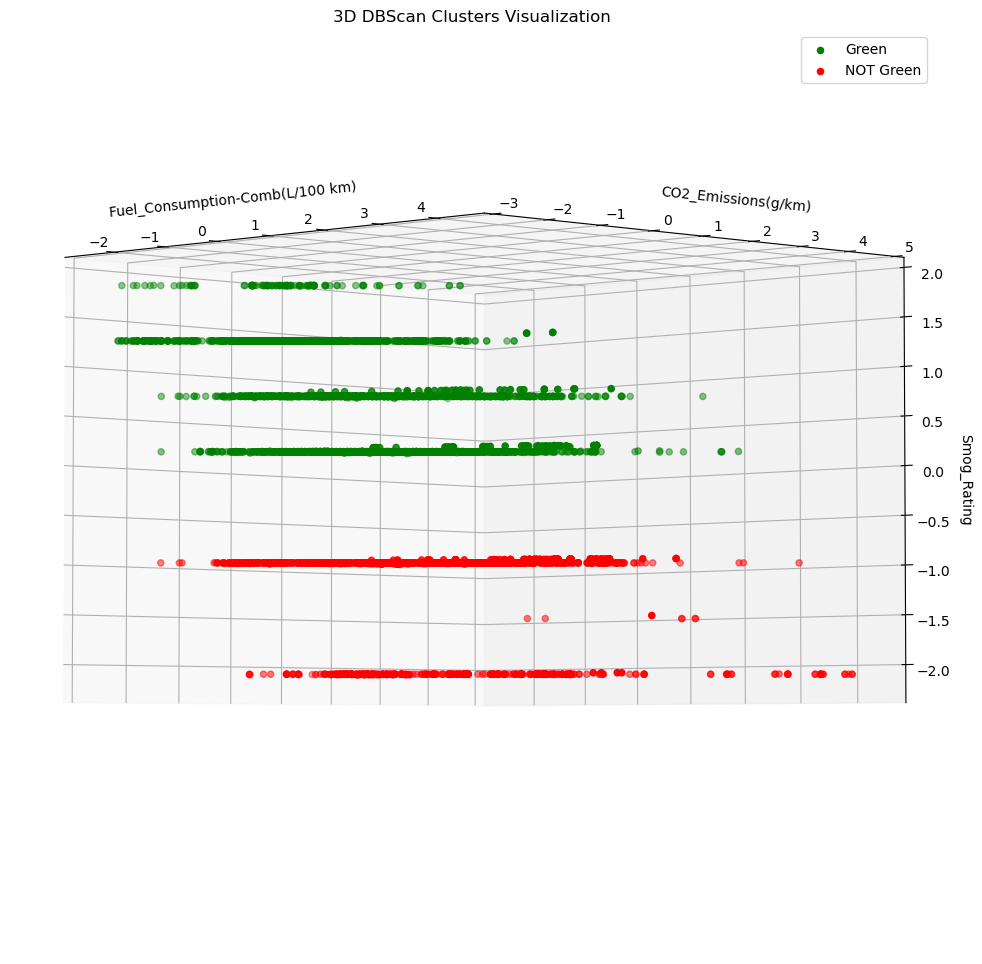

In [254]:
# values are based on experimentation
visualize_dbscan_clusters(-3,-45,df_after_clustering_v2)

Just want to see the bird's eye view of the cluster to see if the separation makes sense.

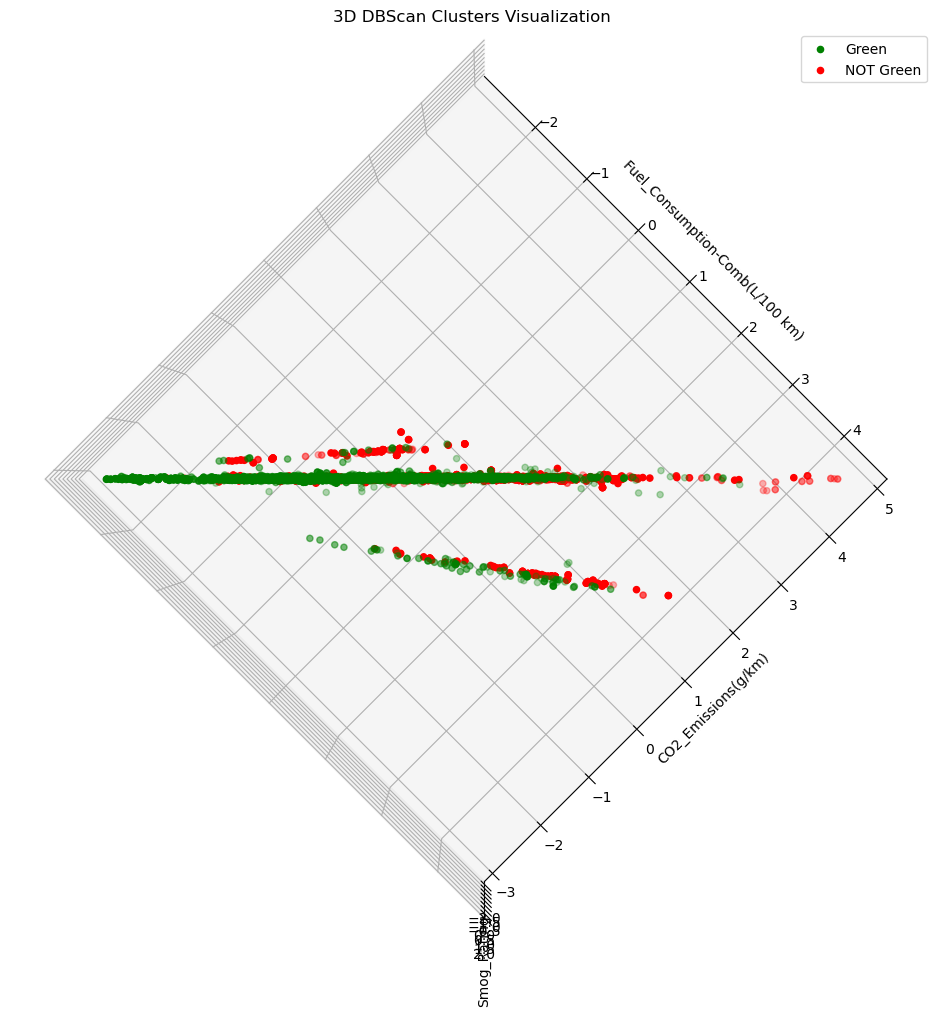

In [255]:
#values for elevation and azimuth are based on experimentation
visualize_dbscan_clusters(90,-50,df_after_clustering_v2)

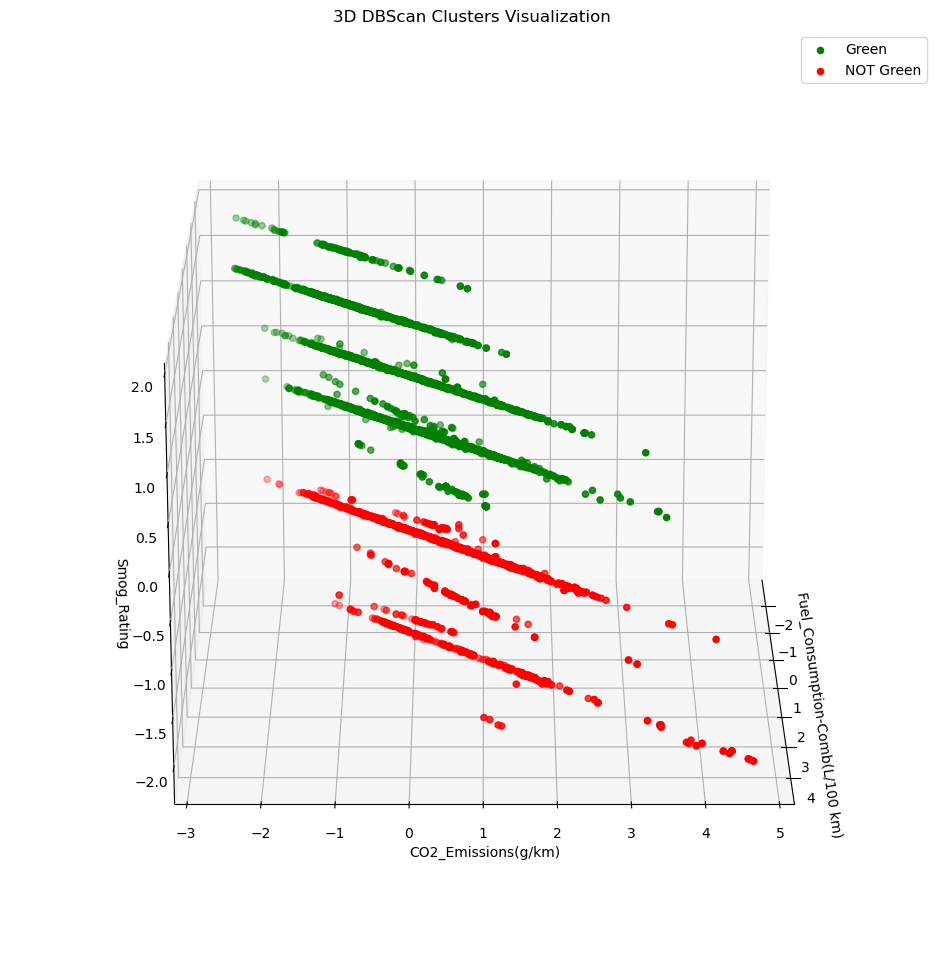

In [260]:
visualize_dbscan_clusters(20,0,df_after_clustering_v2)

**Reflection**  
Although from the 3D view it looked like that the sepration is now done properly given that in the 3D view smog rating above 0 were green in colour and smog ratins below zero were red in color. But seeing in from the bird's eye-view a majority of the red cluster is what I consider as green (low fuel consumption and low co2 emissions). So, the cluster previously formed in reflection, is the best one. Even though only 5 points lie in the red cluster, but at least it is very apparent that they truly are not green. Here, the red clusters mostly lie within the green range. Which also makes sense because the silhouette value for this model is 0.368 which is a lot lower than 0.729. I just wanted to check this anyways despite knowing the silhouette value because I thought perhaps intuitively it may make sense even though it may not make sense with silhouette score. But now that I see it, it low silhouette doesn't make any intuitive sense either (referring to this model)

### Concatenating the Labels to the main dataframe

In [261]:
clean_original_df = pd.read_csv("fuel_cons_rating_clean_merged.csv")
clean_original_df['DBScan_Labels'] = cluster_labels
clean_original_df.head()

,Unnamed: 0,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels
0,0,2017,ACURA,ILX,COMPACT,2.4,4,AM8,Z,9.4,6.8,8.2,192,7,6,0
1,1,2017,ACURA,MDX SH-AWD,SUV - SMALL,3.5,6,AS9,Z,12.6,9.0,11.0,259,4,6,0
2,2,2017,ACURA,MDX SH-AWD ELITE,SUV - SMALL,3.5,6,AS9,Z,12.2,9.0,10.7,251,5,6,0
3,3,2017,ACURA,MDX HYBRID AWD,SUV - SMALL,3.0,6,AM7,Z,9.1,9.0,9.0,210,6,6,0
4,4,2017,ACURA,NSX,TWO-SEATER,3.5,6,AM9,Z,11.1,10.8,11.0,261,4,6,0


In [262]:
# Dropping the random column that appeared randomly on import and has same values as the index
clean_original_df.drop('Unnamed: 0',axis=1,inplace=True)
clean_original_df.head()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels
0,2017,ACURA,ILX,COMPACT,2.4,4,AM8,Z,9.4,6.8,8.2,192,7,6,0
1,2017,ACURA,MDX SH-AWD,SUV - SMALL,3.5,6,AS9,Z,12.6,9.0,11.0,259,4,6,0
2,2017,ACURA,MDX SH-AWD ELITE,SUV - SMALL,3.5,6,AS9,Z,12.2,9.0,10.7,251,5,6,0
3,2017,ACURA,MDX HYBRID AWD,SUV - SMALL,3.0,6,AM7,Z,9.1,9.0,9.0,210,6,6,0
4,2017,ACURA,NSX,TWO-SEATER,3.5,6,AM9,Z,11.1,10.8,11.0,261,4,6,0


In [263]:
clean_original_df.to_csv("fcr_clean_merged_with_DBScanLabels.csv")

# Adding Car Prices to the Dataset
The dataset imported below had some issues and those issues were resolved in sprint 1. Since there weren't sufficient data for Prices I didn't inlcude it in Sprint 2. Adding it now as it is the final version.

In [457]:
grouped_df_carPriceDataset_usd_to_cdn = pd.read_csv("grouped_df_usd_cardataset_conv_cdn_issues_resolved.csv")

In [458]:
grouped_df_carPriceDataset_usd_to_cdn.shape

(154, 5)

In [459]:
grouped_df_carPriceDataset_usd_to_cdn.head()

,Unnamed: 0,Manufacturer,Model,Prod. year,Price
0,0,AUDI,Q5,2017,58981.2596
1,1,AUDI,Q7,2017,16710.6464
2,2,AUDI,Q7,2018,47577.9486
3,3,BMW,428,2017,33028.8534
4,4,BMW,520 D XDRIVE LUXURY,2017,35106.4000


In [460]:
#dropping the unnecessary column
grouped_df_carPriceDataset_usd_to_cdn.drop(columns='Unnamed: 0',inplace=True)

In [461]:
#sanity check
grouped_df_carPriceDataset_usd_to_cdn.columns.to_list()

['Manufacturer', 'Model', 'Prod. year', 'Price']

Now I want to merge this dataset with my fuel conusmption rating dataset that has labels for green or not green.

In [462]:
# Just copying the clean_original_df to which i added dbscan cluster labels to in case I mess something up, 
# so I'll at least have the back up data frame
clean_original_df_with_labels = clean_original_df.copy()
clean_original_df_with_labels.head()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels
0,2017,ACURA,ILX,COMPACT,2.4,4,AM8,Z,9.4,6.8,8.2,192,7,6,0
1,2017,ACURA,MDX SH-AWD,SUV - SMALL,3.5,6,AS9,Z,12.6,9.0,11.0,259,4,6,0
2,2017,ACURA,MDX SH-AWD ELITE,SUV - SMALL,3.5,6,AS9,Z,12.2,9.0,10.7,251,5,6,0
3,2017,ACURA,MDX HYBRID AWD,SUV - SMALL,3.0,6,AM7,Z,9.1,9.0,9.0,210,6,6,0
4,2017,ACURA,NSX,TWO-SEATER,3.5,6,AM9,Z,11.1,10.8,11.0,261,4,6,0


Now I want to use the left join to merge the prices dataset to the dataset with dbscan cluster labels. I am using left join because this will keep all rows of my fuel consumption dataset with cluster labels, and merge the rows where there is a match.

In [463]:
clean_original_df_with_labels_and_price = clean_original_df_with_labels.merge(grouped_df_carPriceDataset_usd_to_cdn[['Manufacturer', 'Model', 'Prod. year', 'Price']], 
                      left_on=['Make', 'Model', 'Model_Year'],  # Use 'left_on'
                      right_on=['Manufacturer', 'Model', 'Prod. year'],  # Use 'right_on'
                      how='left')



clean_original_df_with_labels_and_price[clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price
37,2017,AUDI,Q5,SUV - SMALL,2.0,4,AS8,Z,12.0,8.6,10.5,246,5,6,0,AUDI,2017.0,58981.259600
38,2017,AUDI,Q5,SUV - SMALL,3.0,6,AS8,Z,13.2,9.2,11.4,267,4,6,0,AUDI,2017.0,58981.259600
39,2017,AUDI,Q7,SUV - STANDARD,2.0,4,AS8,Z,11.9,9.6,10.8,253,5,6,0,AUDI,2017.0,16710.646400
40,2017,AUDI,Q7,SUV - STANDARD,3.0,6,AS8,Z,12.6,9.4,11.1,260,4,5,0,AUDI,2017.0,16710.646400
173,2017,CHEVROLET,CAMARO,SUBCOMPACT,2.0,4,AS8,Z,10.9,7.7,9.5,222,5,6,0,CHEVROLET,2017.0,28310.804000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,2019,HYUNDAI,SANTA FE,SUV - SMALL,2.4,4,AS8,X,10.8,8.0,9.6,225,5,5,0,HYUNDAI,2019.0,81882.752467
2638,2019,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.0,7.9,9.1,216,5,5,0,HYUNDAI,2019.0,62515.721800
2816,2019,MAZDA,CX-5,SUV - SMALL,2.0,4,M6,X,9.7,7.7,8.8,206,6,3,0,MAZDA,2019.0,79426.976200
2817,2019,MAZDA,CX-5,SUV - SMALL,2.5,4,AS6,X,9.7,7.8,8.8,206,6,7,0,MAZDA,2019.0,79426.976200


So, 115 rows were a match.

In [464]:
# sanity check on prices
clean_original_df_with_labels_and_price[clean_original_df_with_labels_and_price['Price']>=40000]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price
37,2017,AUDI,Q5,SUV - SMALL,2.0,4,AS8,Z,12.0,8.6,10.5,246,5,6,0,AUDI,2017.0,58981.259600
38,2017,AUDI,Q5,SUV - SMALL,3.0,6,AS8,Z,13.2,9.2,11.4,267,4,6,0,AUDI,2017.0,58981.259600
213,2017,CHEVROLET,IMPALA,FULL-SIZE,2.5,4,AS6,X,10.9,7.9,9.5,224,5,6,0,CHEVROLET,2017.0,50817.767800
333,2017,FORD,EXPLORER,SUV - STANDARD,2.3,4,AS6,X,12.6,8.6,10.8,254,5,6,0,FORD,2017.0,98730.620311
408,2017,FORD,TAURUS,FULL-SIZE,2.0,4,AS6,X,11.8,8.1,10.1,238,5,6,0,FORD,2017.0,73341.031000
512,2017,HYUNDAI,SANTA FE,SUV - SMALL,3.3,6,AS6,X,12.9,9.4,11.3,265,4,6,0,HYUNDAI,2017.0,61343.548503
514,2017,HYUNDAI,SANTA FE SPORT,SUV - SMALL,2.4,4,AS6,X,11.1,8.6,10.0,235,5,7,0,HYUNDAI,2017.0,55048.089000
523,2017,HYUNDAI,TUCSON,SUV - SMALL,1.6,4,AM7,X,9.9,8.5,9.3,221,5,6,0,HYUNDAI,2017.0,53093.049108
524,2017,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.1,7.8,9.0,213,6,6,0,HYUNDAI,2017.0,53093.049108
569,2017,JEEP,CHEROKEE,SUV - SMALL,2.4,4,A9,X,11.0,7.8,9.6,225,5,6,0,JEEP,2017.0,64513.025200


I'll first import prices data from another dataset and then explore the car prices where I have too much Price for older cars that make not much of a sense. Basically I'll filter by Make and Model and see if the price for previous year is available, if so then I will adjust price accordingly. Otherwise I'll research the prices for those, and then estimate what the price should be.

## Another Prices Dataset

In [484]:
canada_car_sale = pd.read_csv("canada_car_sale.csv")

In [485]:
canada_car_sale.shape

(50617, 6)

In [486]:
canada_car_sale.head()

,Unnamed: 0,Name,Production Year,Price,Color,Type
0,0,2005 Toyota MR2,2005,"$18,900 \n+ tax & lic",Red,Convertible
1,1,2007 BMW M6,2007,"$49,995 \n+ tax & lic",Black,Convertible
2,2,2023 Jeep Wrangler,2023,"$64,714 \n+ tax & lic",Silver Zynith,Convertible
3,3,2019 Mazda Miata MX-5,2019,"$38,888 \n+ tax & lic",White,Convertible
4,4,2022 Ford Bronco,2022,"$75,178 \n+ tax & lic",SHADOW BLACK,Convertible


Changing Name to upper case because Make, and Model are in upper case in the main dataset (the one with fuel consumption rating and dbscan labels)

In [487]:
canada_car_sale['Name'] = canada_car_sale['Name'].str.upper()
canada_car_sale.head()

,Unnamed: 0,Name,Production Year,Price,Color,Type
0,0,2005 TOYOTA MR2,2005,"$18,900 \n+ tax & lic",Red,Convertible
1,1,2007 BMW M6,2007,"$49,995 \n+ tax & lic",Black,Convertible
2,2,2023 JEEP WRANGLER,2023,"$64,714 \n+ tax & lic",Silver Zynith,Convertible
3,3,2019 MAZDA MIATA MX-5,2019,"$38,888 \n+ tax & lic",White,Convertible
4,4,2022 FORD BRONCO,2022,"$75,178 \n+ tax & lic",SHADOW BLACK,Convertible


I want to filter this data frame by the make that exist in main data frame before performing any data cleaning since it contains 50,617 rows.

In [488]:
clean_original_df['Make'].unique()

array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FIAT',
       'FORD', 'GENESIS', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI', 'JAGUAR',
       'JEEP', 'KIA', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'LINCOLN',
       'MASERATI', 'MAZDA', 'MERCEDES-BENZ', 'MINI', 'MITSUBISHI',
       'NISSAN', 'PORSCHE', 'RAM', 'ROLLS-ROYCE', 'SMART', 'SUBARU',
       'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'BUGATTI'], dtype=object)

In [489]:
make_list = ['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
           'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FIAT',
           'FORD', 'GENESIS', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI', 'JAGUAR',
           'JEEP', 'KIA', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'LINCOLN',
           'MASERATI', 'MAZDA', 'MERCEDES-BENZ', 'MINI', 'MITSUBISHI',
           'NISSAN', 'PORSCHE', 'RAM', 'ROLLS-ROYCE', 'SMART', 'SUBARU',
           'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'BUGATTI']

In [490]:
canada_car_sale_filterd = canada_car_sale[canada_car_sale['Name'].str.contains('|'.join(make_list), case=False, regex=True)]
canada_car_sale_filterd.shape

(50156, 6)

**Now i want to create Make Column if the Make is found from the make_list in this dataframe's Name column**

In [491]:
canada_car_sale_filterd['Make'] = canada_car_sale_filterd['Name'].str.extract(f'({"|".join(make_list)})')
np.sort(canada_car_sale_filterd['Make'].unique())

C:\Users\Sundus Yawar\AppData\Local\Temp\ipykernel_47352\2984177447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_car_sale_filterd['Make'] = canada_car_sale_filterd['Name'].str.extract(f'({"|".join(make_list)})')


array(['ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW', 'BUICK', 'CHEVROLET',
       'CHRYSLER', 'DODGE', 'FIAT', 'FORD', 'GMC', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JEEP', 'KIA', 'MASERATI', 'MAZDA', 'MERCEDES-BENZ',
       'NISSAN', 'PORSCHE', 'RAM', 'SMART', 'SUBARU', 'TOYOTA',
       'VOLKSWAGEN', 'VOLVO'], dtype=object)

**Now i want to create Model Column if the Model is found from the model_list in this dataframe's Name column**

In [492]:
# Getting unique model names
model_list = (clean_original_df['Model'].unique()).tolist()
model_list

['ILX',
 'MDX SH-AWD',
 'MDX SH-AWD ELITE',
 'MDX HYBRID AWD',
 'NSX',
 'RDX AWD',
 'RLX HYBRID',
 'TLX',
 'TLX SH-AWD',
 '4C',
 '4C SPIDER',
 'GIULIA',
 'GIULIA AWD',
 'GIULIA QUADRIFOGLIO',
 'DB11 V12',
 'RAPIDE S',
 'VANQUISH',
 'V12 VANTAGE S',
 'A3',
 'A3 QUATTRO',
 'A3 CABRIOLET QUATTRO',
 'A4 ULTRA',
 'A4 QUATTRO',
 'A4 ALLROAD QUATTRO',
 'A5 QUATTRO',
 'A5 CABRIOLET QUATTRO',
 'A6 QUATTRO',
 'A7 QUATTRO',
 'A8',
 'A8L',
 'Q3',
 'Q3 QUATTRO',
 'Q5',
 'Q7',
 'R8',
 'R8 SPYDER',
 'RS 7',
 'S3',
 'S5',
 'S5 CABRIOLET',
 'S6',
 'S7',
 'S8',
 'SQ5',
 'TT COUPE QUATTRO',
 'TT ROADSTER QUATTRO',
 'TTS COUPE QUATTRO',
 'BENTAYGA',
 'CONTINENTAL GT',
 'CONTINENTAL GT CONVERTIBLE',
 'FLYING SPUR',
 'MULSANNE',
 'MULSANNE EWB',
 '230I CABRIOLET',
 '230I COUPE',
 '230I XDRIVE CABRIOLET',
 '230I XDRIVE COUPE',
 '320I',
 '320I XDRIVE',
 '328D XDRIVE',
 '328D XDRIVE TOURING',
 '330I XDRIVE',
 '330I XDRIVE GRAN TURISMO',
 '330I XDRIVE TOURING',
 '340I',
 '340I XDRIVE',
 '340I XDRIVE GRAN TURISM

I applied the same approach to extract model but it resulted in multiple errors so now I am going to use another approach.

In [493]:
def remove_year_model_from_name(row):
    # extracting year, make and name
    year = str(row['Production Year'])
    make = str(row['Make'])
    name = row['Name']
    # these if statements remove year and make from the name column so only model is left
    if year in name:
        name = name.replace(year, '').strip()
    if make in name:
        name = name.replace(make, '').strip()
    return name

In [494]:
canada_car_sale_filterd['Name'] = canada_car_sale_filterd.apply(remove_year_model_from_name,axis=1)
canada_car_sale_filterd.head()

C:\Users\Sundus Yawar\AppData\Local\Temp\ipykernel_47352\3727466819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_car_sale_filterd['Name'] = canada_car_sale_filterd.apply(remove_year_model_from_name,axis=1)


,Unnamed: 0,Name,Production Year,Price,Color,Type,Make
0,0,MR2,2005,"$18,900 \n+ tax & lic",Red,Convertible,TOYOTA
1,1,M6,2007,"$49,995 \n+ tax & lic",Black,Convertible,BMW
2,2,WRANGLER,2023,"$64,714 \n+ tax & lic",Silver Zynith,Convertible,JEEP
3,3,MIATA MX-5,2019,"$38,888 \n+ tax & lic",White,Convertible,MAZDA
4,4,BRONCO,2022,"$75,178 \n+ tax & lic",SHADOW BLACK,Convertible,FORD


In [495]:
#Now i'll rename the Name column to Model
canada_car_sale_filterd.rename(columns={'Name': 'Model'}, inplace=True)
canada_car_sale_filterd.head()

C:\Users\Sundus Yawar\AppData\Local\Temp\ipykernel_47352\313950352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_car_sale_filterd.rename(columns={'Name': 'Model'}, inplace=True)


,Unnamed: 0,Model,Production Year,Price,Color,Type,Make
0,0,MR2,2005,"$18,900 \n+ tax & lic",Red,Convertible,TOYOTA
1,1,M6,2007,"$49,995 \n+ tax & lic",Black,Convertible,BMW
2,2,WRANGLER,2023,"$64,714 \n+ tax & lic",Silver Zynith,Convertible,JEEP
3,3,MIATA MX-5,2019,"$38,888 \n+ tax & lic",White,Convertible,MAZDA
4,4,BRONCO,2022,"$75,178 \n+ tax & lic",SHADOW BLACK,Convertible,FORD


In [496]:
# remove comma from price and keep digits only
canada_car_sale_filterd['Price'] = canada_car_sale_filterd['Price'].str.replace(',', '', regex=True) 
canada_car_sale_filterd['Price'] = canada_car_sale_filterd['Price'].str.extract(r'(\d+)').astype(float)
canada_car_sale_filterd.head()

C:\Users\Sundus Yawar\AppData\Local\Temp\ipykernel_47352\1424820116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_car_sale_filterd['Price'] = canada_car_sale_filterd['Price'].str.replace(',', '', regex=True)
C:\Users\Sundus Yawar\AppData\Local\Temp\ipykernel_47352\1424820116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_car_sale_filterd['Price'] = canada_car_sale_filterd['Price'].str.extract(r'(\d+)').astype(float)


,Unnamed: 0,Model,Production Year,Price,Color,Type,Make
0,0,MR2,2005,18900.0,Red,Convertible,TOYOTA
1,1,M6,2007,49995.0,Black,Convertible,BMW
2,2,WRANGLER,2023,64714.0,Silver Zynith,Convertible,JEEP
3,3,MIATA MX-5,2019,38888.0,White,Convertible,MAZDA
4,4,BRONCO,2022,75178.0,SHADOW BLACK,Convertible,FORD


In [497]:
# filter it so it only contains data for relevant years
canada_car_sale_filterd = canada_car_sale_filterd[canada_car_sale_filterd['Production Year']>=2017]
canada_car_sale_filterd.shape

(39628, 7)

In [498]:
# Soritng by Production year and Make to see if there are any duplicates
canada_car_sale_filterd.sort_values(by=['Production Year', 'Make'])

,Unnamed: 0,Model,Production Year,Price,Color,Type,Make
6791,6791,COLORADO,2017,28995.0,White,Pickup Truck,CHEVROLET
6840,6840,COLORADO,2017,28995.0,White,Pickup Truck,CHEVROLET
6889,6889,COLORADO,2017,28995.0,White,Pickup Truck,CHEVROLET
6938,6938,COLORADO,2017,28995.0,White,Pickup Truck,CHEVROLET
6987,6987,COLORADO,2017,28995.0,White,Pickup Truck,CHEVROLET
...,...,...,...,...,...,...,...
2239,2239,GR86,2023,31490.0,0D4S RAVEN,Coupe,TOYOTA
2288,2288,GR86,2023,31490.0,0D4S RAVEN,Coupe,TOYOTA
2337,2337,GR86,2023,31490.0,0D4S RAVEN,Coupe,TOYOTA
2386,2386,GR86,2023,31490.0,0D4S RAVEN,Coupe,TOYOTA


Seems like this dataset has a lot of duplicates. So, I'll remove duplicates.

In [499]:
canada_car_sale_filterd.drop(columns='Unnamed: 0',inplace=True)

In [500]:
canada_car_sale_filterd.head()

,Model,Production Year,Price,Color,Type,Make
2,WRANGLER,2023,64714.0,Silver Zynith,Convertible,JEEP
3,MIATA MX-5,2019,38888.0,White,Convertible,MAZDA
4,BRONCO,2022,75178.0,SHADOW BLACK,Convertible,FORD
5,SLC,2017,55798.0,Red,Convertible,MERCEDES-BENZ
6,MUSTANG,2017,45800.0,Red,Convertible,FORD


In [501]:
# removing duplicate rows
canada_car_sale_filterd = canada_car_sale_filterd.drop_duplicates()

In [502]:
# just checking if i still have nay duplicates
(canada_car_sale_filterd.sort_values(by=['Production Year', 'Make'])).tail(10)

,Model,Production Year,Price,Color,Type,Make
22126,ELANTRA,2023,24389.0,Black,Sedan,HYUNDAI
22127,ELANTRA,2023,28539.0,Grey,Sedan,HYUNDAI
22128,ELANTRA,2023,26339.0,Blue,Sedan,HYUNDAI
22130,ELANTRA,2023,22089.0,White,Sedan,HYUNDAI
2,WRANGLER,2023,64714.0,Silver Zynith,Convertible,JEEP
12,WRANGLER,2023,71459.0,High Velocity,Convertible,JEEP
24540,SPORTAGE,2023,32845.0,Grey,SUV,KIA
24541,SPORTAGE,2023,40245.0,Grey,SUV,KIA
24547,SPORTAGE,2023,38663.0,Red,SUV,KIA
867,GR86,2023,31490.0,0D4S RAVEN,Coupe,TOYOTA


In [503]:
clean_original_df_with_labels_and_price.shape

(6951, 18)

In [504]:
# as u can see for same make model and year we have multiple prices that's why I am grouping by mean.
canada_car_sale_filterd = canada_car_sale_filterd.groupby(['Make','Model','Production Year'])['Price'].mean().reset_index()

In [505]:
clean_original_df_with_labels_and_price = clean_original_df_with_labels_and_price.merge(
    canada_car_sale_filterd[['Make', 'Model', 'Production Year', 'Price']],
    left_on=['Make', 'Model', 'Model_Year'], # for clean_original_df_with_labels_and_price
    right_on = ['Make', 'Model', 'Production Year'], # for canada_car_sale_filtered
    how='left',
    suffixes=('', '_right')
)

# Fill missing 'Price' values in 'Price' column with values from 'Price_right' column
clean_original_df_with_labels_and_price['Price'].fillna(clean_original_df_with_labels_and_price['Price_right'], inplace=True)

# Drop the 'Price_right' column
clean_original_df_with_labels_and_price.drop('Price_right', axis=1, inplace=True)

In [506]:
clean_original_df_with_labels_and_price[clean_original_df_with_labels_and_price['Price'].notna()]['Vehicle_Class'].unique()

array(['SUV - SMALL', 'SUV - STANDARD', 'SUBCOMPACT',
       'PICKUP TRUCK - SMALL', 'COMPACT', 'FULL-SIZE', 'MID-SIZE',
       'MINIVAN', 'PICKUP TRUCK - STANDARD', 'STATION WAGON - SMALL',
       'TWO-SEATER', 'MINICOMPACT'], dtype=object)

## Correcting the Strange Prices

I am trying to see if I have prices for earlier year for models with strange costs based on the results above. So, if they do have prices for previous year then these stranges prices can be fixed based on that. Otherwise I'll research prices for current year and estimate the strange ones based on that. These filters were created based on earlier filteringof the data frame for prices > 40k

In [507]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='FORD') & (clean_original_df_with_labels_and_price['Model']=='EXPLORER') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
333,2017,FORD,EXPLORER,SUV - STANDARD,2.3,4,AS6,X,12.6,8.6,10.8,254,5,6,0,FORD,2017.0,98730.620311,NaN


=============================================================================================================================== <font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value of 78.7k for a 2017 model, I'll need to look it up and estimate the price myself**</font>  
**Ford Explorer 2017**
- 78k for the used Ford Explorer doesn't make sense, because it's 2023 Platinum version cost 64.9k. Starts at 45k. And given that it is 2017 model it should cost about 30k.
- https://www.ford.ca/suvs/explorer/?searchid=700000001048934&campaignid=71700000010172368&gclid=9ce31ed6ac4218a41a187bfdabb5faaa&gclsrc=3p.ds&msclkid=9ce31ed6ac4218a41a187bfdabb5faaa
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Correcting the prices will be a repititive task, so creating a function that'll take, make, model, year and the updated price then update the price accordingly.**

In [508]:
def correct_prices(make,model,year,price):
    filter_condition = (clean_original_df_with_labels_and_price['Make'] == make) & (clean_original_df_with_labels_and_price['Model'] == model) & (clean_original_df_with_labels_and_price['Model_Year'] == year)
    # update price
    clean_original_df_with_labels_and_price.loc[filter_condition, 'Price'] = price
    return clean_original_df_with_labels_and_price

In [510]:
# correct the price
correct_prices('FORD','EXPLORER',2017,30000)
#sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='FORD') & (clean_original_df_with_labels_and_price['Model']=='EXPLORER') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
333,2017,FORD,EXPLORER,SUV - STANDARD,2.3,4,AS6,X,12.6,8.6,10.8,254,5,6,0,FORD,2017.0,30000.0,NaN


**Ford Taurus**

In [511]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='FORD') & (clean_original_df_with_labels_and_price['Model']=='TAURUS') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
408,2017,FORD,TAURUS,FULL-SIZE,2.0,4,AS6,X,11.8,8.1,10.1,238,5,6,0,FORD,2017.0,73341.031,NaN


================================================================================================================================ <font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value of 58.49k for a 2017 model of this vehicle, I'll need to look it up and estimate the price myself**</font>  
**Ford Taurus 2017**
- This is a sedan, and shouldn't cost 58.5k, I checked this website and prices range from 10k to 36.9k from 2016 to 2019. So, for a 2017 model I'd say the average price should be 28K
- https://www.autotrader.ca/cars/ford/taurus/ 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [513]:
# correct the price
correct_prices('FORD','TAURUS',2017,28000.00)
#sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='FORD') & (clean_original_df_with_labels_and_price['Model']=='TAURUS') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
408,2017,FORD,TAURUS,FULL-SIZE,2.0,4,AS6,X,11.8,8.1,10.1,238,5,6,0,FORD,2017.0,28000.0,NaN


**Jeep Cherokee**

In [516]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='JEEP') & (clean_original_df_with_labels_and_price['Model']=='CHEROKEE') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
569,2017,JEEP,CHEROKEE,SUV - SMALL,2.4,4,A9,X,11.0,7.8,9.6,225,5,6,0,JEEP,2017.0,64513.0252,NaN
570,2017,JEEP,CHEROKEE,SUV - SMALL,3.2,6,A9,X,11.4,8.3,10.0,234,5,6,0,JEEP,2017.0,64513.0252,NaN
1645,2018,JEEP,CHEROKEE,SUV - SMALL,3.2,6,A9,X,11.4,8.3,10.0,234,5,3,0,NaN,NaN,25750.0000,2018.0
5649,2022,JEEP,CHEROKEE,SUV - SMALL,2.0,4,A9,X,10.4,7.6,9.1,214,5,5,0,NaN,NaN,53700.0000,2022.0
5650,2022,JEEP,CHEROKEE,SUV - SMALL,2.4,4,A9,X,10.8,7.5,9.3,219,5,6,0,NaN,NaN,53700.0000,2022.0
5651,2022,JEEP,CHEROKEE,SUV - SMALL,3.2,6,A9,X,11.9,8.2,10.2,240,5,5,0,NaN,NaN,53700.0000,2022.0


================================================================================================================================ **Initial Thought:** <font color = 'red'>For cases like these where I have reasonable prices data from another data set available and a price value that doesn't make sense from another dataset, I'll remove the price value obtained from the dataset that yielded not so good prices. And then do the interpolation. So, how can I tell the difference between the 2 datasets? Where Prod. year value is present but Production Year value is NaN, that's the dataset with proper values. SO I'll make Price value NaN based on this filter. Then filter by the make model and year, but first sort by Make, Model, and Year then **linearly** interpolate so it can perform interpolation correctly.</font>  
**Note:** I tried that however, it just ended up copy pasting the values backward rather than using the year to figure out linear relationship between year and price.  
**Now:** <font color = 'green'>I am just going to estimate based on the given correct prices, the price for 2017 model of this vehicle. So, I'll take difference between 2022 price and 2018 price then divide that difference by 4 (because 2022-2018=4) so I get rate of change per year. Then I know 2018 value subtract this value by difference per year value. 53700-25750 = 27,950, 27,950/4 = 6,987.5, now 25750-6987.5=18,762.</font>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [517]:
# correct the price
correct_prices('JEEP','CHEROKEE',2017,18762.00)
#sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='JEEP') & (clean_original_df_with_labels_and_price['Model']=='CHEROKEE') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
569,2017,JEEP,CHEROKEE,SUV - SMALL,2.4,4,A9,X,11.0,7.8,9.6,225,5,6,0,JEEP,2017.0,18762.0,NaN
570,2017,JEEP,CHEROKEE,SUV - SMALL,3.2,6,A9,X,11.4,8.3,10.0,234,5,6,0,JEEP,2017.0,18762.0,NaN
1645,2018,JEEP,CHEROKEE,SUV - SMALL,3.2,6,A9,X,11.4,8.3,10.0,234,5,3,0,NaN,NaN,25750.0,2018.0
5649,2022,JEEP,CHEROKEE,SUV - SMALL,2.0,4,A9,X,10.4,7.6,9.1,214,5,5,0,NaN,NaN,53700.0,2022.0
5650,2022,JEEP,CHEROKEE,SUV - SMALL,2.4,4,A9,X,10.8,7.5,9.3,219,5,6,0,NaN,NaN,53700.0,2022.0
5651,2022,JEEP,CHEROKEE,SUV - SMALL,3.2,6,A9,X,11.9,8.2,10.2,240,5,5,0,NaN,NaN,53700.0,2022.0


**Hyundai Sonata**

In [439]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='HYUNDAI') & (clean_original_df_with_labels_and_price['Model']=='SONATA') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
518,2017,HYUNDAI,SONATA,FULL-SIZE,2.0,4,AS6,X,10.5,7.6,9.2,216,6,6,0,HYUNDAI,2017.0,28647.468750,NaN
519,2017,HYUNDAI,SONATA,FULL-SIZE,2.4,4,AS6,X,9.4,6.7,8.2,194,7,7,0,HYUNDAI,2017.0,28647.468750,NaN
1597,2018,HYUNDAI,SONATA,FULL-SIZE,2.0,4,AS8,X,10.4,7.4,9.1,212,5,5,0,HYUNDAI,2018.0,58143.909091,NaN
1598,2018,HYUNDAI,SONATA,FULL-SIZE,2.4,4,AS6,X,9.8,6.9,8.5,202,6,5,0,HYUNDAI,2018.0,58143.909091,NaN
5617,2022,HYUNDAI,SONATA,FULL-SIZE,1.6,4,AS8,X,8.8,6.4,7.7,183,6,5,0,NaN,NaN,38389.000000,2022.0
5618,2022,HYUNDAI,SONATA,FULL-SIZE,2.5,4,AM8,X,10.1,7.2,8.8,208,6,5,0,NaN,NaN,38389.000000,2022.0
5619,2022,HYUNDAI,SONATA,FULL-SIZE,2.5,4,AS8,X,8.8,6.4,7.7,182,6,7,0,NaN,NaN,38389.000000,2022.0


================================================================================================================================ <font color = 'green'>**Since it was similar case as above I tried the same method of interpolation which resulted in copy paste rather than true linear interpolation, so now I'll just estimate based on current value known for price from good dataset. I'll estimate a deprication in price to be 3,000/per year.**</font>  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [518]:
# correct the price
correct_prices('HYUNDAI','SONATA',2018,26389.00)
correct_prices('HYUNDAI','SONATA',2017,23389.00)
#sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='HYUNDAI') & (clean_original_df_with_labels_and_price['Model']=='SONATA') & clean_original_df_with_labels_and_price['Price'].notna()]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
518,2017,HYUNDAI,SONATA,FULL-SIZE,2.0,4,AS6,X,10.5,7.6,9.2,216,6,6,0,HYUNDAI,2017.0,23389.0,NaN
519,2017,HYUNDAI,SONATA,FULL-SIZE,2.4,4,AS6,X,9.4,6.7,8.2,194,7,7,0,HYUNDAI,2017.0,23389.0,NaN
1597,2018,HYUNDAI,SONATA,FULL-SIZE,2.0,4,AS8,X,10.4,7.4,9.1,212,5,5,0,HYUNDAI,2018.0,26389.0,NaN
1598,2018,HYUNDAI,SONATA,FULL-SIZE,2.4,4,AS6,X,9.8,6.9,8.5,202,6,5,0,HYUNDAI,2018.0,26389.0,NaN
5617,2022,HYUNDAI,SONATA,FULL-SIZE,1.6,4,AS8,X,8.8,6.4,7.7,183,6,5,0,NaN,NaN,38389.0,2022.0
5618,2022,HYUNDAI,SONATA,FULL-SIZE,2.5,4,AM8,X,10.1,7.2,8.8,208,6,5,0,NaN,NaN,38389.0,2022.0
5619,2022,HYUNDAI,SONATA,FULL-SIZE,2.5,4,AS8,X,8.8,6.4,7.7,182,6,7,0,NaN,NaN,38389.0,2022.0


**Hyundai Tucson**

In [440]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='HYUNDAI') & (clean_original_df_with_labels_and_price['Model']=='TUCSON') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
523,2017,HYUNDAI,TUCSON,SUV - SMALL,1.6,4,AM7,X,9.9,8.5,9.3,221,5,6,0,HYUNDAI,2017.0,42345.708333,NaN
524,2017,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.1,7.8,9.0,213,6,6,0,HYUNDAI,2017.0,42345.708333,NaN
1601,2018,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.1,7.8,9.0,213,5,3,0,HYUNDAI,2018.0,50308.714286,2018.0
2638,2019,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.0,7.9,9.1,216,5,5,0,HYUNDAI,2019.0,49861.000000,NaN


================================================================================================================================ <font color = 'blue'>**For this model price will be based on research because none of the prices indicated make any sense**</font>  
**Hyundai Tucson**  
- Price ranges from 31.156k to 45.156k for this year Hyundai Tucson (gasoline powered), so 50.3k for 2018 model doesn't make sense. So, I'll take average for current price so 31.156k + 45.156k = 38.156k.
- 2023: 38.156k so I'll estimate price deprication of 2000/year
- 2019: 38156-(2000x4) = 30,156
- 2018: 30,156 - 2000 = 28,156
- 2017: 28,156 - 2000 = 26,156
- https://www.hyundaicanada.com/en/shopping-tools/buildandprice 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [519]:
# correct the price
correct_prices('HYUNDAI','TUCSON',2019,30156.00)
correct_prices('HYUNDAI','TUCSON',2018,28156.00)
correct_prices('HYUNDAI','TUCSON',2017,26156.00)
#sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='HYUNDAI') & (clean_original_df_with_labels_and_price['Model']=='TUCSON') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
523,2017,HYUNDAI,TUCSON,SUV - SMALL,1.6,4,AM7,X,9.9,8.5,9.3,221,5,6,0,HYUNDAI,2017.0,26156.0,NaN
524,2017,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.1,7.8,9.0,213,6,6,0,HYUNDAI,2017.0,26156.0,NaN
1601,2018,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.1,7.8,9.0,213,5,3,0,HYUNDAI,2018.0,28156.0,2018.0
2638,2019,HYUNDAI,TUCSON,SUV - SMALL,2.0,4,AS6,X,10.0,7.9,9.1,216,5,5,0,HYUNDAI,2019.0,30156.0,NaN


**Kia Sorento**

In [441]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='KIA') & (clean_original_df_with_labels_and_price['Model']=='SORENTO') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
1700,2018,KIA,SORENTO,SUV - SMALL,2.4,4,AS6,X,11.2,8.3,9.9,234,5,5,0,KIA,2018.0,51432.5,NaN


=============================================================================================================================== <font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value of 51.4k for a 2018 model for this vehicle, I'll need to look it up and estimate the price myself**</font>  
**Kia Sorento 2018**
- Price ranges from 38k to 49.4k for this year, so for 2018 model it doesn't make sense for mean price to be $51.4k. So, I'd say 25k as mean price would make more sense for 2018 model. 
- I'll take average of this range then use that as 2023 price: 43,700
- I'll estimate deprication per year to be 2000/year
- 2023 - 2018 = 5
- price for 2018 = 43700 - (2000x5) = 33700
- https://www.kia.ca/en/shopping-tools/build-and-price?isDeliveryAndDestination=true&currentVehicleTrimCode=SR856P&step=2&exteriorColourCode=EB&interiorColourCode=Black+Leather&paymentFrequency=WEEKLY&kilometerAllowance=KMALL16&loanTerm=84&leaseTerm=60&yearCashCustomize=5&loanCashYrRange=24000&method=lease&model=Sorento&year=2023&engineType=Gas 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [520]:
# correct the price
correct_prices('KIA','SORENTO',2018,33700.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='KIA') & (clean_original_df_with_labels_and_price['Model']=='SORENTO') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
1700,2018,KIA,SORENTO,SUV - SMALL,2.4,4,AS6,X,11.2,8.3,9.9,234,5,5,0,KIA,2018.0,33700.0,NaN


**Mercedes-Benz CLA 250**

In [442]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='MERCEDES-BENZ') & (clean_original_df_with_labels_and_price['Model']=='CLA 250') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
1841,2018,MERCEDES-BENZ,CLA 250,COMPACT,2.0,4,AM7,Z,9.6,6.6,8.2,193,6,5,0,MERCEDES-BENZ,2018.0,58018.0,NaN


=============================================================================================================================== <font color = 'blue'>**Although Mercedes Benz is an expensive vehicle, still it doesn't make sense for 2018 model to cost 58k, so I'll need to look it up and estimate the price myself**</font>  
**Mercedes Benz CLA 250 2018**  
- Costs 56,045 this is a price for this year. So for 2018 model I'd say a mean price of 35k would make more sense. Because there is no way that 2018 model has a mean price of 58k
- 2023-2018 = 5
- deprecation estimate: 1,500/year I am making 1500 deprecation estimate because expensive cars dont deprecate too fast.
- 56045 - (1500 x 5) = 48545
- https://www.mercedes-benz.ca/en/inventory/Mercedes-Benz-Mississauga/5607/CLA/CPE/CLA250C4/W1K5J4HB3PN377568
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [521]:
# correct the price
correct_prices('MERCEDES-BENZ','CLA 250',2018,48545.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='MERCEDES-BENZ') & (clean_original_df_with_labels_and_price['Model']=='CLA 250') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
1841,2018,MERCEDES-BENZ,CLA 250,COMPACT,2.0,4,AM7,Z,9.6,6.6,8.2,193,6,5,0,MERCEDES-BENZ,2018.0,48545.0,NaN


**Toyota Avalon**

In [443]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='TOYOTA') & (clean_original_df_with_labels_and_price['Model']=='AVALON') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
967,2017,TOYOTA,AVALON,MID-SIZE,3.5,6,AS6,X,11.4,7.7,9.7,226,5,6,0,TOYOTA,2017.0,37633.0,NaN
2058,2018,TOYOTA,AVALON,MID-SIZE,3.5,6,AS6,X,11.4,7.7,9.7,226,5,3,0,TOYOTA,2018.0,62095.0,NaN


<font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value, I'll need to research the current price and then estimate the price**</font>  
**Toyota Avalon**  
- Current price range is 36.8k-43.8k, so the mean price of 62k for 2018 model doesn't make sense.
- Current year avg price: 36800+43800/2 = 40300
- estimate deprecation value 2000/year
- 2023-2018 = 5
- 2018 price: 40300 - (2000 x 5) = 30300
- 2017 price = 28300
- https://toyotacarnews.com/2023-toyota-avalon/

In [522]:
# correct the price
correct_prices('TOYOTA','AVALON',2018,30300.00)
correct_prices('TOYOTA','AVALON',2017,28300.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='TOYOTA') & (clean_original_df_with_labels_and_price['Model']=='AVALON') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
967,2017,TOYOTA,AVALON,MID-SIZE,3.5,6,AS6,X,11.4,7.7,9.7,226,5,6,0,TOYOTA,2017.0,28300.0,NaN
2058,2018,TOYOTA,AVALON,MID-SIZE,3.5,6,AS6,X,11.4,7.7,9.7,226,5,3,0,TOYOTA,2018.0,30300.0,NaN


**Hyundai Santa FE**

In [444]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='HYUNDAI') & (clean_original_df_with_labels_and_price['Model']=='SANTA FE') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
512,2017,HYUNDAI,SANTA FE,SUV - SMALL,3.3,6,AS6,X,12.9,9.4,11.3,265,4,6,0,HYUNDAI,2017.0,48926.103448,2017.0
1591,2018,HYUNDAI,SANTA FE,SUV - SMALL,3.3,6,AS6,X,12.9,9.4,11.3,265,4,3,0,HYUNDAI,2018.0,49162.916667,NaN
2627,2019,HYUNDAI,SANTA FE,SUV - SMALL,2.4,4,AS8,X,10.8,8.0,9.6,225,5,5,0,HYUNDAI,2019.0,65307.666667,NaN
3668,2020,HYUNDAI,SANTA FE,SUV - SMALL,2.4,4,AS8,X,10.8,8.0,9.6,225,5,5,0,HYUNDAI,2020.0,97235.000000,NaN
4635,2021,HYUNDAI,SANTA FE,SUV - SMALL,2.5,4,AS8,X,9.6,8.5,9.1,214,5,7,0,NaN,NaN,49995.000000,2021.0


<font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value, I'll need to research the current price and then estimate the price**</font>  
**Hyundai Santa Fe**
- Current price ranges from 40.7k to 51.6k, so none of the listed prices make sense.
- 2023 avg price: (40700 + 51600)/2 = 46150
- estimate deprecation value 2000/year
- 2023-2021 = 2
- 2021 price: 46150 - (2000 x 2) = 42150
- 2020 price: 40150
- 2019 price: 38150
- 2018 price: 36150
- 2017 price = 34150
- https://www.hyundaicanada.com/en/shopping-tools/buildandprice/build?step=2&modelId=62b97cbb-d853-4a39-b2b0-8c16aa941cad


In [523]:
# correct the price
correct_prices('HYUNDAI','SANTA FE',2021,42150.00)
correct_prices('HYUNDAI','SANTA FE',2020,40150.00)
correct_prices('HYUNDAI','SANTA FE',2019,38150.00)
correct_prices('HYUNDAI','SANTA FE',2018,36150.00)
correct_prices('HYUNDAI','SANTA FE',2017,34150.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='HYUNDAI') & (clean_original_df_with_labels_and_price['Model']=='SANTA FE') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
512,2017,HYUNDAI,SANTA FE,SUV - SMALL,3.3,6,AS6,X,12.9,9.4,11.3,265,4,6,0,HYUNDAI,2017.0,34150.0,2017.0
1591,2018,HYUNDAI,SANTA FE,SUV - SMALL,3.3,6,AS6,X,12.9,9.4,11.3,265,4,3,0,HYUNDAI,2018.0,36150.0,NaN
2627,2019,HYUNDAI,SANTA FE,SUV - SMALL,2.4,4,AS8,X,10.8,8.0,9.6,225,5,5,0,HYUNDAI,2019.0,38150.0,NaN
3668,2020,HYUNDAI,SANTA FE,SUV - SMALL,2.4,4,AS8,X,10.8,8.0,9.6,225,5,5,0,HYUNDAI,2020.0,40150.0,NaN
4635,2021,HYUNDAI,SANTA FE,SUV - SMALL,2.5,4,AS8,X,9.6,8.5,9.1,214,5,7,0,NaN,NaN,42150.0,2021.0


**Mazda CX-5**

In [445]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='MAZDA') & (clean_original_df_with_labels_and_price['Model']=='CX-5') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
704,2017,MAZDA,CX-5,SUV - SMALL,2.0,4,M6,X,9.4,7.4,8.5,199,6,6,0,NaN,NaN,27995.0,2017.0
705,2017,MAZDA,CX-5,SUV - SMALL,2.5,4,AS6,X,9.8,7.7,8.6,204,6,6,0,NaN,NaN,27995.0,2017.0
2816,2019,MAZDA,CX-5,SUV - SMALL,2.0,4,M6,X,9.7,7.7,8.8,206,6,3,0,MAZDA,2019.0,63349.0,NaN
2817,2019,MAZDA,CX-5,SUV - SMALL,2.5,4,AS6,X,9.7,7.8,8.8,206,6,7,0,MAZDA,2019.0,63349.0,NaN
3862,2020,MAZDA,CX-5,SUV - SMALL,2.5,4,AS6,X,9.7,7.8,8.8,206,6,7,0,NaN,NaN,38800.0,2020.0


<font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value, I'll need to research the current price and then estimate the price**</font>  
**Mazda CX-5**  
- Current price ranges from 31.3k-41k, none of the prices make sense.
- 2023 avg price: (31.3k + 41k)/2 = 36150
- estimate deprecation value 1500/year
- 2023-2020 = 3
- 2020 price: (36150 - 1500x3) = 31650
- 2019 price: 30150
- 2017 price = 27150
- https://www.mazda.ca/en/shopping/build-and-price/#/2023/CX-5/

In [524]:
# correct the price
correct_prices('MAZDA','CX-5',2020,31650.00)
correct_prices('MAZDA','CX-5',2019,30150.00)
correct_prices('MAZDA','CX-5',2017,27150.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='MAZDA') & (clean_original_df_with_labels_and_price['Model']=='CX-5') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
704,2017,MAZDA,CX-5,SUV - SMALL,2.0,4,M6,X,9.4,7.4,8.5,199,6,6,0,NaN,NaN,27150.0,2017.0
705,2017,MAZDA,CX-5,SUV - SMALL,2.5,4,AS6,X,9.8,7.7,8.6,204,6,6,0,NaN,NaN,27150.0,2017.0
2816,2019,MAZDA,CX-5,SUV - SMALL,2.0,4,M6,X,9.7,7.7,8.8,206,6,3,0,MAZDA,2019.0,30150.0,NaN
2817,2019,MAZDA,CX-5,SUV - SMALL,2.5,4,AS6,X,9.7,7.8,8.8,206,6,7,0,MAZDA,2019.0,30150.0,NaN
3862,2020,MAZDA,CX-5,SUV - SMALL,2.5,4,AS6,X,9.7,7.8,8.8,206,6,7,0,NaN,NaN,31650.0,2020.0


**Audi Q5**

In [446]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='AUDI') & (clean_original_df_with_labels_and_price['Model']=='Q5') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
37,2017,AUDI,Q5,SUV - SMALL,2.0,4,AS8,Z,12.0,8.6,10.5,246,5,6,0,AUDI,2017.0,47042.0,NaN
38,2017,AUDI,Q5,SUV - SMALL,3.0,6,AS8,Z,13.2,9.2,11.4,267,4,6,0,AUDI,2017.0,47042.0,NaN


=============================================================================================================================== <font color = 'blue'>**Although Audi is an expensive vehicle, I just want to ensure if the value of 47k for 2017 vehicle make any sense**</font>  
- 2024 year price is ranges from 53.9k-65.97k
- Avg 2024 price: 59935
- estimate deprecation value 2000/year
- 2017 price = 59935 - (2000 x 7) = 45935
- https://www.audi.ca/ca/web/en/models/q5/q5/build-price.html  
  
<font color = 'green'>**Since my calculation and the written price are only off by 2k I'd say this price makes sense and no ocrrection is necessary**</font>
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Chevrolet Impala**

In [447]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='CHEVROLET') & (clean_original_df_with_labels_and_price['Model']=='IMPALA') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
213,2017,CHEVROLET,IMPALA,FULL-SIZE,2.5,4,AS6,X,10.9,7.9,9.5,224,5,6,0,CHEVROLET,2017.0,40531.0,NaN


=============================================================================================================================== <font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value of 40.5kk for a 2017 model for this vehicle, I'll need to look it up and estimate the price myself**</font>  
- in 2020 it cost ranged from 36.2k - 43.3k
- average 2020 price: 39750
- estimate deprecation value 2000/year
- 2017 price: 39750 - 6000 = 33750
- https://www.bing.com/search?q=chevrolet+impala+price&qs=n&form=QBRE&sp=-1&lq=0&pq=chevrolet+impala+price&sc=10-22&sk=&cvid=528FD2A71882492683205CA6527A7997&ghsh=0&ghacc=0&ghpl=
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [525]:
# correct the price
correct_prices('CHEVROLET','IMPALA',2017,33750.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='CHEVROLET') & (clean_original_df_with_labels_and_price['Model']=='IMPALA') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
213,2017,CHEVROLET,IMPALA,FULL-SIZE,2.5,4,AS6,X,10.9,7.9,9.5,224,5,6,0,CHEVROLET,2017.0,33750.0,NaN


**Mercedes-Benz G550**

In [448]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='MERCEDES-BENZ') & (clean_original_df_with_labels_and_price['Model']=='G 550') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
768,2017,MERCEDES-BENZ,G 550,SUV - STANDARD,4.0,8,AS7,Z,19.0,16.6,17.9,401,1,5,0,MERCEDES-BENZ,2017.0,42965.0,NaN


=============================================================================================================================== <font color = 'green'>**Mercedes Benz is an expensive vehicle, so like in Audi's case it makes sense for 2017 model to cost 42.9k**</font>  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Mitsubishi Outlander**

In [449]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='MITSUBISHI') & (clean_original_df_with_labels_and_price['Model']=='OUTLANDER') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
831,2017,MITSUBISHI,OUTLANDER,SUV - SMALL,2.4,4,AV6,X,9.2,7.5,8.4,197,6,7,0,MITSUBISHI,2017.0,40142.0,NaN


=============================================================================================================================== <font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value of 40.1k for a 2017 model for this vehicle, I'll need to look it up and estimate the price myself**</font>  
- 2024 price range from 32.2k - 44.5k
- 2024 avg price: (32.2k + 44.5k)/2 = 38350
- estimate deprecation value 1000/year
- 2017 price: 38350 - 7000 = 31350
- https://www.mitsubishi-motors.ca/en/vehicles/outlander/trims
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [526]:
# correct the price
correct_prices('MITSUBISHI','OUTLANDER',2017,31350.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='MITSUBISHI') & (clean_original_df_with_labels_and_price['Model']=='OUTLANDER') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
831,2017,MITSUBISHI,OUTLANDER,SUV - SMALL,2.4,4,AV6,X,9.2,7.5,8.4,197,6,7,0,MITSUBISHI,2017.0,31350.0,NaN


**Toyota Tacaoma**

In [450]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='TOYOTA') & (clean_original_df_with_labels_and_price['Model']=='TACOMA') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
995,2017,TOYOTA,TACOMA,PICKUP TRUCK - SMALL,2.7,4,AS6,X,12.1,10.1,11.2,263,4,7,0,TOYOTA,2017.0,49237.0,NaN
996,2017,TOYOTA,TACOMA,PICKUP TRUCK - SMALL,3.5,6,AS6,X,12.6,10.0,11.4,268,4,7,0,TOYOTA,2017.0,49237.0,NaN


=============================================================================================================================== <font color = 'blue'>**Since there's no other price data to determine the legitimacy of this value of 49.2k for a 2017 model for this vehicle, I'll need to look it up and estimate the price myself**</font>  
- 2023 price range: 44.7k - 57.6k
- 2023 avg price: (44.7k + 57.6k)/2 = 51150
- estimate deprecation value 2000/year
- 2017 price = 51150 - (2000 x 6) = 39150
- https://www.toyota.ca/toyota/en/build-price/tacoma?series=CP4&model=DZ5BNT&year=2023
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [527]:
# correct the price
correct_prices('TOYOTA','TACOMA',2017,39150.00)
# sanity check
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Make']=='TOYOTA') & (clean_original_df_with_labels_and_price['Model']=='TACOMA') &(clean_original_df_with_labels_and_price['Price'].notna())]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Manufacturer,Prod. year,Price,Production Year
995,2017,TOYOTA,TACOMA,PICKUP TRUCK - SMALL,2.7,4,AS6,X,12.1,10.1,11.2,263,4,7,0,TOYOTA,2017.0,39150.0,NaN
996,2017,TOYOTA,TACOMA,PICKUP TRUCK - SMALL,3.5,6,AS6,X,12.6,10.0,11.4,268,4,7,0,TOYOTA,2017.0,39150.0,NaN


# Dropping Irrelevant Columns and Exporting the Final DataFrame

In [531]:
clean_original_df_with_labels_and_price.drop(columns = ['Manufacturer','Prod. year','Production Year'],inplace=True)
#sanity check
clean_original_df_with_labels_and_price.columns.to_list()

['Model_Year',
 'Make',
 'Model',
 'Vehicle_Class',
 'Engine_Size(L)',
 'Cylinders',
 'Transmission',
 'Fuel_Type',
 'Fuel_Consumption-City(L/100 km)',
 'Fuel_Consumption-Hwy(L/100 km)',
 'Fuel_Consumption-Comb(L/100 km)',
 'CO2_Emissions(g/km)',
 'CO2_Rating',
 'Smog_Rating',
 'DBScan_Labels',
 'Price']

In [532]:
# export the file containing prices data
clean_original_df_with_labels_and_price.to_csv("Sprint3_resulting_dataframe.csv")

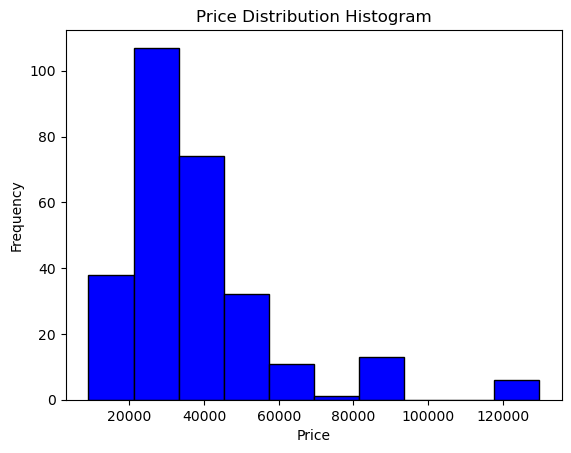

In [535]:
# to determine the price ranges for my app I want to see the distribution of prices
plt.hist(clean_original_df_with_labels_and_price['Price'], bins=10, color='blue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution Histogram')
plt.show()

In [541]:
clean_original_df_with_labels_and_price[(clean_original_df_with_labels_and_price['Price']>=60000) & (clean_original_df_with_labels_and_price['Price']<=70000)]

,Model_Year,Make,Model,Vehicle_Class,Engine_Size(L),Cylinders,Transmission,Fuel_Type,Fuel_Consumption-City(L/100 km),Fuel_Consumption-Hwy(L/100 km),Fuel_Consumption-Comb(L/100 km),CO2_Emissions(g/km),CO2_Rating,Smog_Rating,DBScan_Labels,Price
5397,2022,CHRYSLER,PACIFICA,MINIVAN,3.6,6,A9,X,12.4,8.4,10.6,249,5,5,0,61132.5
5485,2022,FORD,MUSTANG,SUBCOMPACT,2.3,4,A10,X,11.0,7.4,9.3,220,5,5,0,62484.0
5486,2022,FORD,MUSTANG,SUBCOMPACT,2.3,4,AS10,X,11.4,7.9,9.8,231,5,5,0,62484.0
5488,2022,FORD,MUSTANG,SUBCOMPACT,2.3,4,M6,X,11.5,8.2,10.0,236,5,5,0,62484.0
5490,2022,FORD,MUSTANG,SUBCOMPACT,5.0,8,AS10,X,15.2,9.7,12.7,298,4,3,0,62484.0
5491,2022,FORD,MUSTANG,SUBCOMPACT,5.0,8,M6,X,16.1,10.1,13.4,314,3,3,0,62484.0
6000,2022,RAM,1500,PICKUP TRUCK - STANDARD,5.7,8,A8,X,16.2,10.5,13.6,320,3,5,0,68100.0
6078,2022,TOYOTA,SIENNA,MINIVAN,2.5,4,AV,X,6.6,6.5,6.6,154,7,7,0,68230.0
6083,2022,TOYOTA,TUNDRA,PICKUP TRUCK - STANDARD,3.4,6,AS10,X,13.1,10.1,11.8,277,4,5,0,68888.0


In [542]:
clean_original_df_with_labels_and_price[clean_original_df_with_labels_and_price['DBScan_Labels'] == 0]['DBScan_Labels'].unique()

array([0], dtype=int64)

In [544]:
clean_original_df_with_labels_and_price['Vehicle_Class'].unique().tolist()

['COMPACT',
 'SUV - SMALL',
 'TWO-SEATER',
 'MID-SIZE',
 'MINICOMPACT',
 'SUBCOMPACT',
 'STATION WAGON - SMALL',
 'FULL-SIZE',
 'SUV - STANDARD',
 'SPECIAL PURPOSE VEHICLE',
 'PICKUP TRUCK - SMALL',
 'VAN - PASSENGER',
 'PICKUP TRUCK - STANDARD',
 'MINIVAN',
 'STATION WAGON - MID-SIZE']

Legend for Transmission:  
`| A: Automatic | AM: Automated Manual | AS: Automatic with Select Shift | AV: Continuously Variable | M: Manual | 3-10: Number of Gears |`